In [1]:
from functions import *
import argparse
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs import utils
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')
import os
from os import path
from matplotlib import colors
import cmasher as cmr
from scipy import ndimage, misc
from regions import Regions
from regions import RectangleSkyRegion, PixCoord, RectanglePixelRegion, PolygonSkyRegion, PolygonPixelRegion
from astropy.coordinates import Angle, SkyCoord
from astropy.cosmology import Planck18
from astropy import units as u

plt.rcParams.update({'lines.linewidth':0.3})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'cmu serif'

SMALL_SIZE = 9
MEDIUM_SIZE = 10
BIGGER_SIZE = 11

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


rootdirectory='/Volumes/TARDIS/Work/askap/leakage_corrected/'
sourcefile='/Users/emma/GitHub/possum-tools/DataProcess/pilot_sources.txt'
fig_directory='/Users/emma/OneDrive/PhD/thesis/Figures/new/'
cmap_redblue=cmr.get_sub_cmap('twilight_shifted', 0.1, 0.9)
cmap_redblue.set_bad('gray',0.5)
twilight=plt.cm.twilight
twilight.set_bad('gray',0.5)
tw1=cmr.get_sub_cmap('twilight_shifted', 0, 0.5)
tw2=cmr.get_sub_cmap('twilight_shifted_r', 0, 0.5)

sources=np.loadtxt(sourcefile,dtype='str')
src='2046-5107'
#
listpos=np.argwhere(sources[:,0]==src)

#Galacitc RM map
galacicRMfile='/Volumes/TARDIS/Work/askap/Faraday_cutout_pilot.fits'
galacticRMerrs='/Volumes/TARDIS/Work/askap/Faraday_error_pilot.fits'

ra=str(sources[listpos,1][0][0])
dec=str(sources[listpos,2][0][0])
xmin=int(sources[listpos,12]) 
ymin=int(sources[listpos,13]) 
xmax=int(sources[listpos,14]) 
ymax=int(sources[listpos,15]) 
z=float(sources[listpos,8]) 

galacticRM,gRMerr=galactic_rm(SkyCoord(ra,dec),galacicRMfile,galacticRMerrs)

directory=rootdirectory+src+'/'

regions = Regions.read(directory+src+'_ds9.reg')
f = open(directory+src+'_ds9.reg','r')
region_stringlist=f.readlines()[3:]


nreg=len(regions)
cmaplims=np.linspace(0,1,nreg+1)
cmapmid=(cmaplims[:-1]+cmaplims[1:])/2

print("Reading in the fits files")
pkRM,pkRMhead=fitsopen(directory+'FDF_peakRM_fitted_corrected.fits')
RMerrs,RMerrshead=fitsopen(directory+src+'_RM_error.fits')
dd,ddhead=fitsopen(directory+src+'_FDF_peakRM_dropdeg.fits')
burn,burnhead=fitsopen(directory+src+'_burn_k.fits')
wcs=WCS(ddhead)

def arcsectokpc(arcmin):
    arcsec=arcmin*60
    arcsec_per_kpc=Planck18.arcsec_per_kpc_comoving(z) # scale in arcsec per kpc
    kpc=(arcsec*u.arcsec)/(arcsec_per_kpc*u.kpc)
    return kpc
def kpctoarcsec(kpc):
    arcsec_per_kpc=Planck18.arcsec_per_kpc_comoving(z) # scale in arcsec per kpc
    arcsec=kpc*arcsec_per_kpc*u.kpc/u.arcsec
    arcmin=arcsec/60
    return arcmin

Reading in the fits files


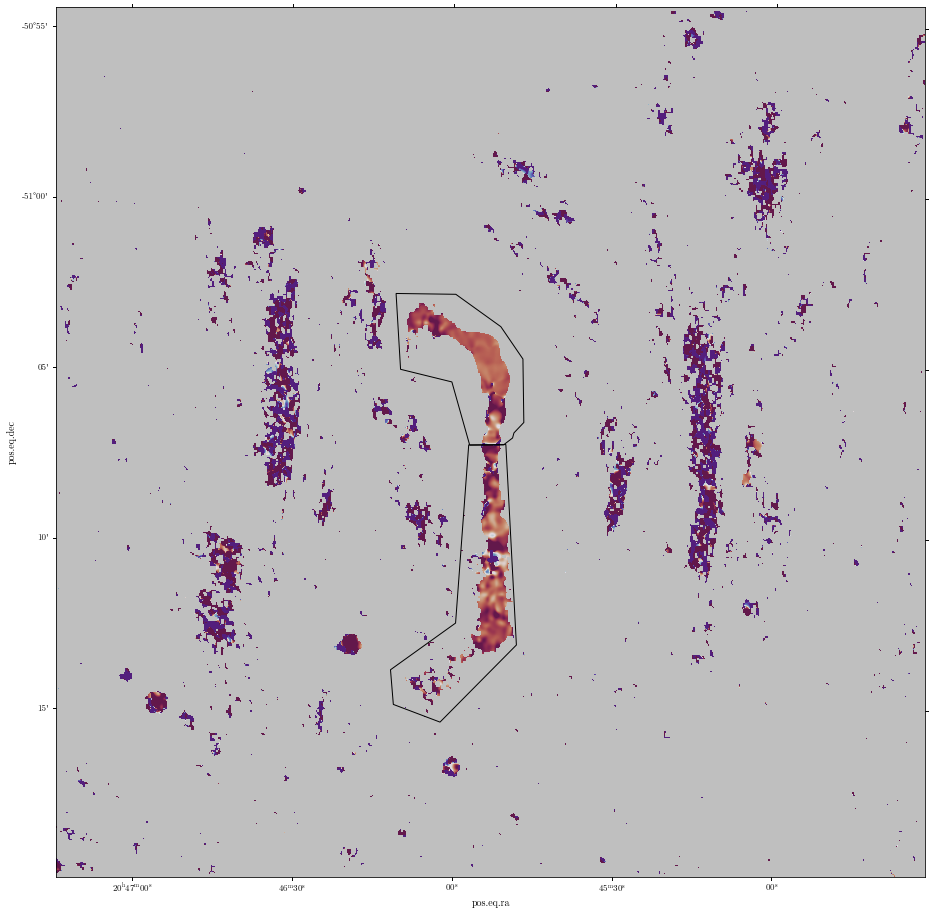

['N_lobe', 'S_lobe']


In [2]:
plt.figure(figsize=(16,16))
ax=plt.subplot(projection=wcs)
ax.imshow(pkRM,origin='lower',vmin=-100,vmax=100,cmap=cmap_redblue)

i=0
labels=[]
for reg in regions:
    pixel_region = reg.to_pixel(wcs)
    pixel_region.plot(color='k')
    regstring=region_stringlist[i]
    label=regstring.split("{")[-1][:-2]
    labels.append(label)
    i+=1
plt.show()
print(labels)

In [3]:
region_array=np.zeros(shape=(nreg,pkRM.shape[0],pkRM.shape[1]),dtype='bool')

try:
    i=0
    for reg in labels:
        region=np.loadtxt(directory+src+'_region_'+reg+'.txt')
        region_array[i,:,:]=region
        i+=1
except:
    for i in range(xmin,xmax):
        print(i)
        for j in range(ymin,ymax):
            if np.isfinite(pkRM[j,i]) and np.isfinite(burn[j,i]):
                pixcoords=PixCoord(x=i,y=j)
                k=0
                for reg in regions:
                    pixel_region = reg.to_pixel(wcs)
                    if pixel_region.contains(pixcoords):
                        region_array[k,j,i]=True
                    k+=1
    for i in range(0,region_array.shape[0]):
        label=labels[i]
        out=directory+src+'_region_'+label+'.txt'
        print(out)
        np.savetxt(out,region_array[i,:,:])            

In [4]:
print(region_array.shape[0])

2


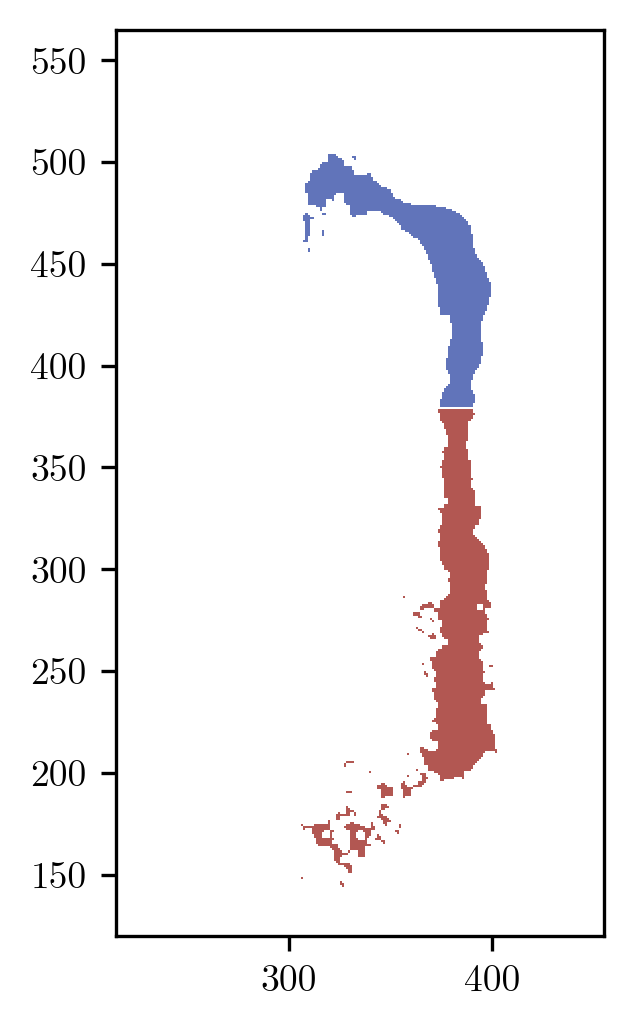

In [5]:
plt.figure(dpi=300)
region_array=np.ma.masked_where(region_array==False,region_array)
for i in range(0,nreg):
    cmap_region=cmr.get_sub_cmap('twilight',cmaplims[i],cmaplims[i+1])
    cmap_region.set_bad('gray',0)
    plt.imshow(region_array[i,:,:],origin='lower',cmap=cmap_region,vmin=-100,vmax=100)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.show()

In [6]:
rm_regions=np.multiply(pkRM,np.where(region_array==True,1,np.nan))
k_regions=np.multiply(burn,np.where(region_array==True,1,np.nan))

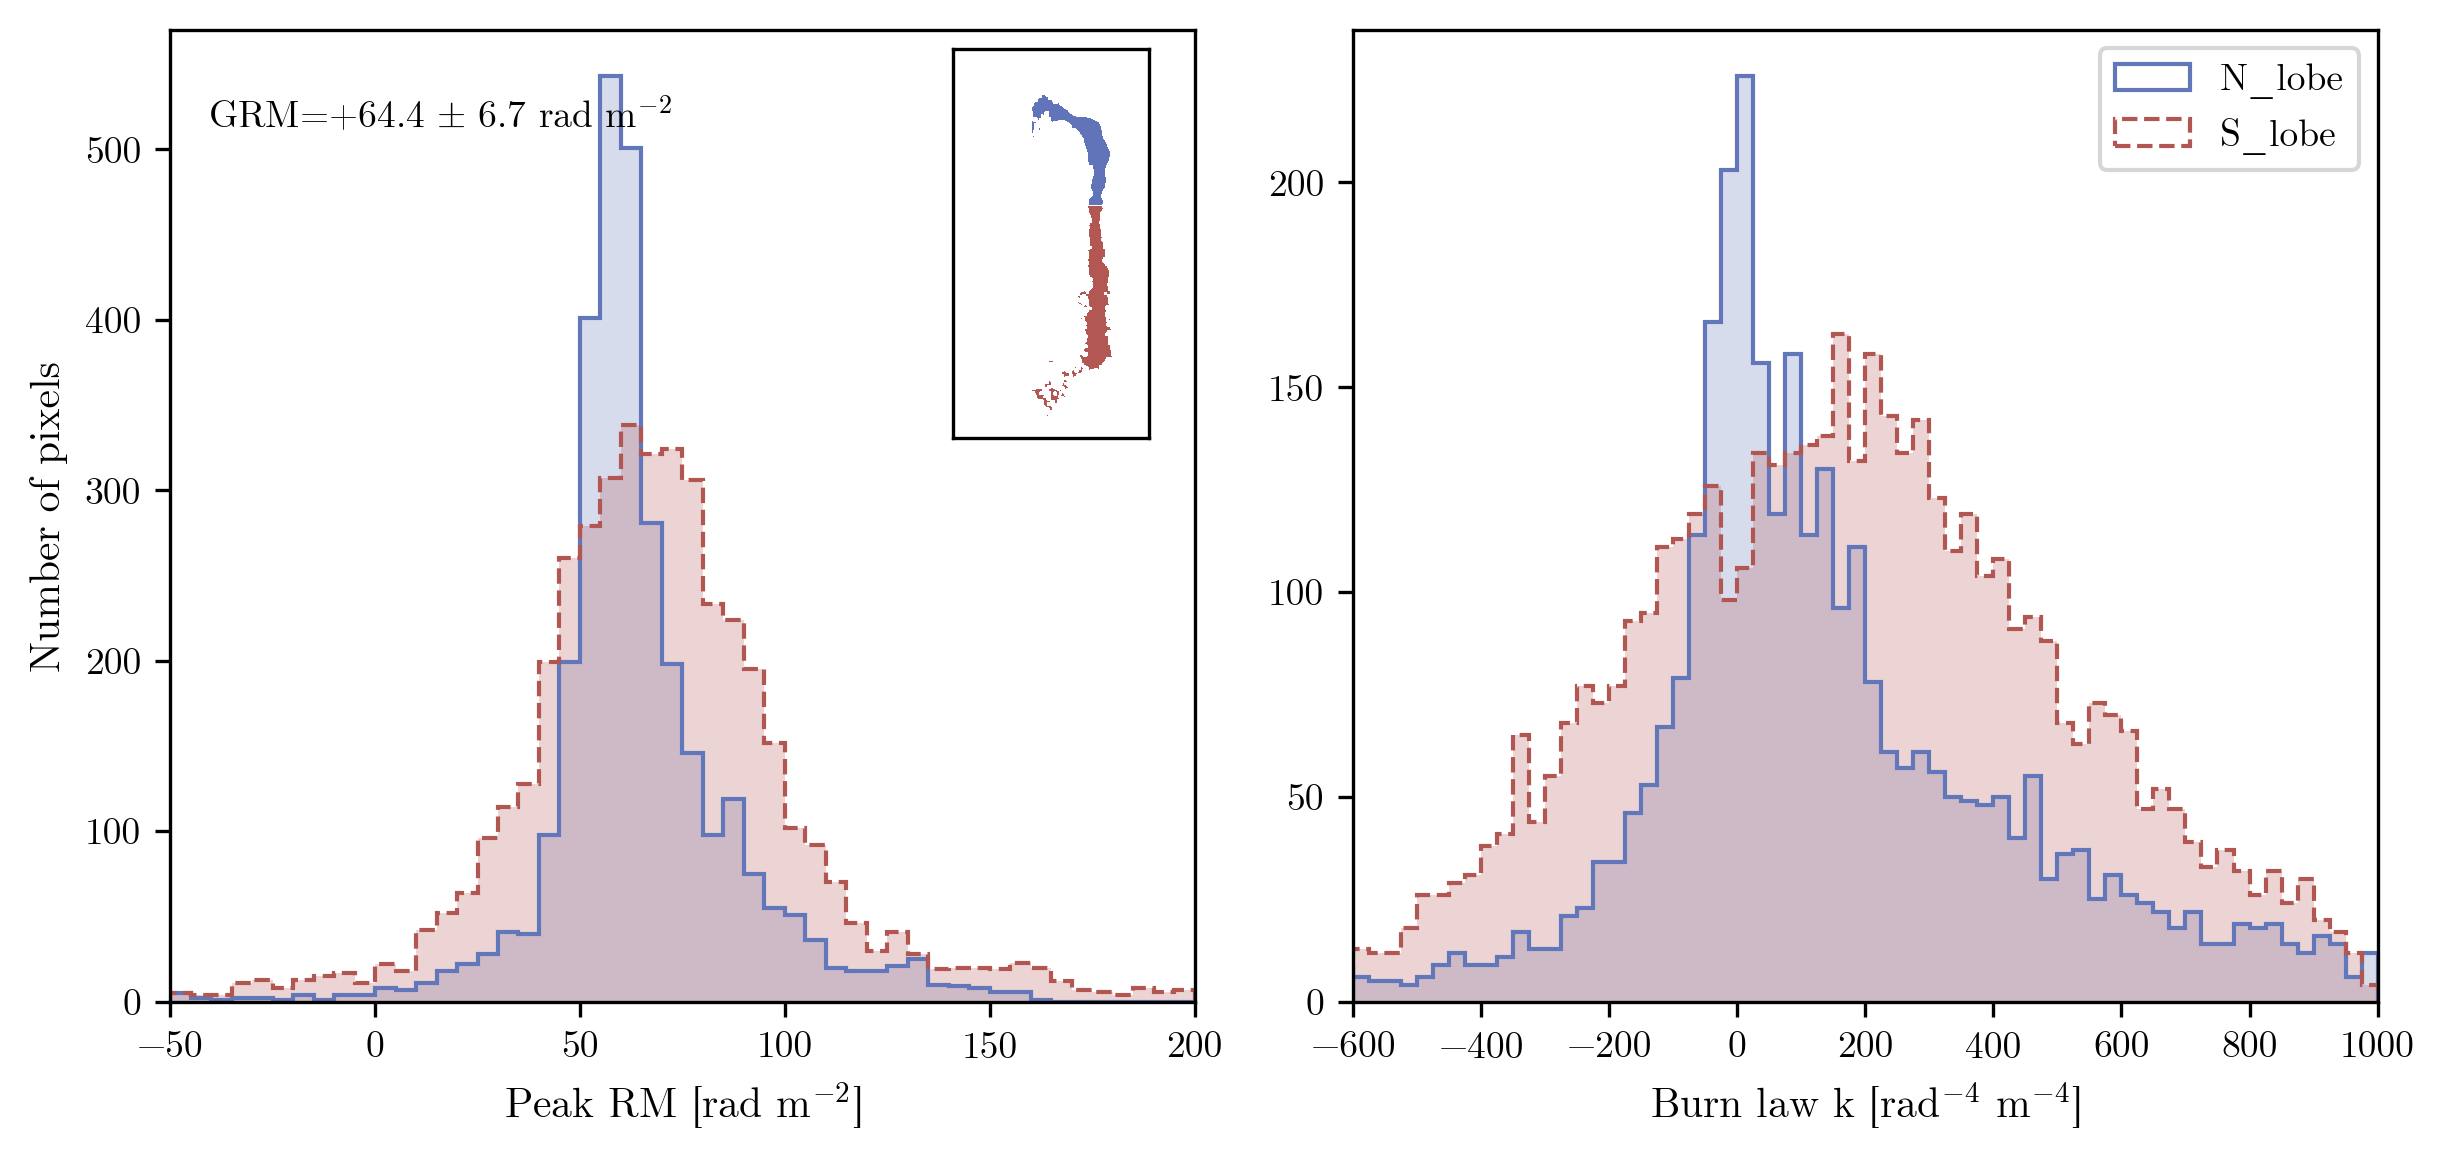

In [7]:
rm_min=-50
rm_max=200
binsize=5
bins_array=np.arange(start=rm_min,stop=rm_max+binsize,step=binsize)
bincentres=bins_array[0:-1]+(binsize/2.)

burn_min=-600
burn_max=1000
kbinsize=25
kbins_array=np.arange(start=burn_min,stop=burn_max+kbinsize,step=kbinsize)
kbincentres=kbins_array[0:-1]+(kbinsize/2.)

linestyles=['solid','dashed','dotted','dashdot',(0, (5, 1))]
#hatches=[' ',' ','\\\\\\',' ',' ']
hatches=[' ',' ',' ',' ',' ']

fig=plt.figure(dpi=300,figsize=(8.25,8.25/2))

ax=plt.subplot(121,adjustable='box')
ax2=plt.subplot(122,adjustable='box')

galacticRM-gRMerr

kwargs = dict(histtype='step', bins=bins_array,linewidth=1)
kwargs2 = dict(histtype='stepfilled', bins=bins_array,linewidth=1,alpha=1/(nreg+2))

kkwargs = dict(histtype='step', bins=kbins_array,linewidth=1)
kkwargs2 = dict(histtype='stepfilled', bins=kbins_array,linewidth=1,alpha=1/(nreg+2))

f = open(directory+src+'_dist_stats.txt', 'w')


for i in range(0,nreg):
    hist=ax.hist(np.ndarray.flatten(rm_regions[i,:,:]),**kwargs,color=twilight(cmapmid[i]),linestyle=linestyles[i],label=labels[i],hatch=hatches[i])
    hist2=ax.hist(np.ndarray.flatten(rm_regions[i,:,:]),**kwargs2,color=twilight(cmapmid[i]))
    print(labels[i],file=f)
    print('Median RM= {}'.format(np.nanmedian(np.ndarray.flatten(rm_regions[i,:,:]))),file=f)
    print('Mean RM= {}'.format(np.nanmean(np.ndarray.flatten(rm_regions[i,:,:]))),file=f)
    print('std RM= {}'.format(np.nanstd(np.ndarray.flatten(rm_regions[i,:,:]))),file=f)

    hist3=ax2.hist(np.ndarray.flatten(k_regions[i,:,:]),**kkwargs,color=twilight(cmapmid[i]),linestyle=linestyles[i],label=labels[i],hatch=hatches[i])
    hist4=ax2.hist(np.ndarray.flatten(k_regions[i,:,:]),**kkwargs2,color=twilight(cmapmid[i]))
    
    print('Median k= {}'.format(np.nanmedian(np.ndarray.flatten(k_regions[i,:,:]))),file=f)
    print('Mean k= {}'.format(np.nanmean(np.ndarray.flatten(k_regions[i,:,:]))),file=f)
    print('std k= {} \n'.format(np.nanstd(np.ndarray.flatten(k_regions[i,:,:]))),file=f)

if nreg>=2:
    ax2.legend()
    
ax.set_xlim(rm_min,rm_max)
ax.annotate(text='GRM={:+.1f}'.format(galacticRM)+r'$\,\pm\,$'+'{:.1f}'.format(gRMerr)+r' rad m$^{-2}$',xy=(0.085,0.89),xycoords='figure fraction',color='k',fontsize=SMALL_SIZE)
ax.set_ylabel('Number of pixels')
ax.set_xlabel(r'Peak RM [rad m$^{-2}$]')
ax2.set_xlabel(r'Burn law k [rad$^{-4}$ m$^{-4}$]')
ax2.set_xlim(burn_min,burn_max)


axins = ax.inset_axes([0.66, 0.58, 0.4, 0.4])
for i in range(0,nreg):
    cmap_region=cmr.get_sub_cmap('twilight',cmaplims[i],cmaplims[i+1])
    cmap_region.set_bad('gray',0)
    axins.imshow(region_array[i,:,:],origin='lower',cmap=cmap_region,vmin=-100,vmax=100)
    
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.set_xlim(xmin,xmax-10)
axins.set_ylim(ymin,ymax-10)
axins.set_xticks([])
axins.set_yticks([])



plt.tight_layout()
plt.savefig(fig_directory+src+'hists.png',dpi=300,transparent=True)
plt.show()

try:
    aaaah=asd
except:
    "break time!!"


In [8]:
from scipy import stats
ks_rm=np.nan*np.ones(shape=(nreg,nreg))
ks_k=np.nan*np.ones(shape=(nreg,nreg))
for i in range(0,nreg):
    for j in range(0,nreg):
        ks=stats.ks_2samp(np.ndarray.flatten(rm_regions[i,:,:]),np.ndarray.flatten(rm_regions[j,:,:]))
        ks_rm[i,j]=ks[1]
        ksk=stats.ks_2samp(np.ndarray.flatten(k_regions[i,:,:]),np.ndarray.flatten(k_regions[j,:,:]))
        ks_k[i,j]=ksk[1]

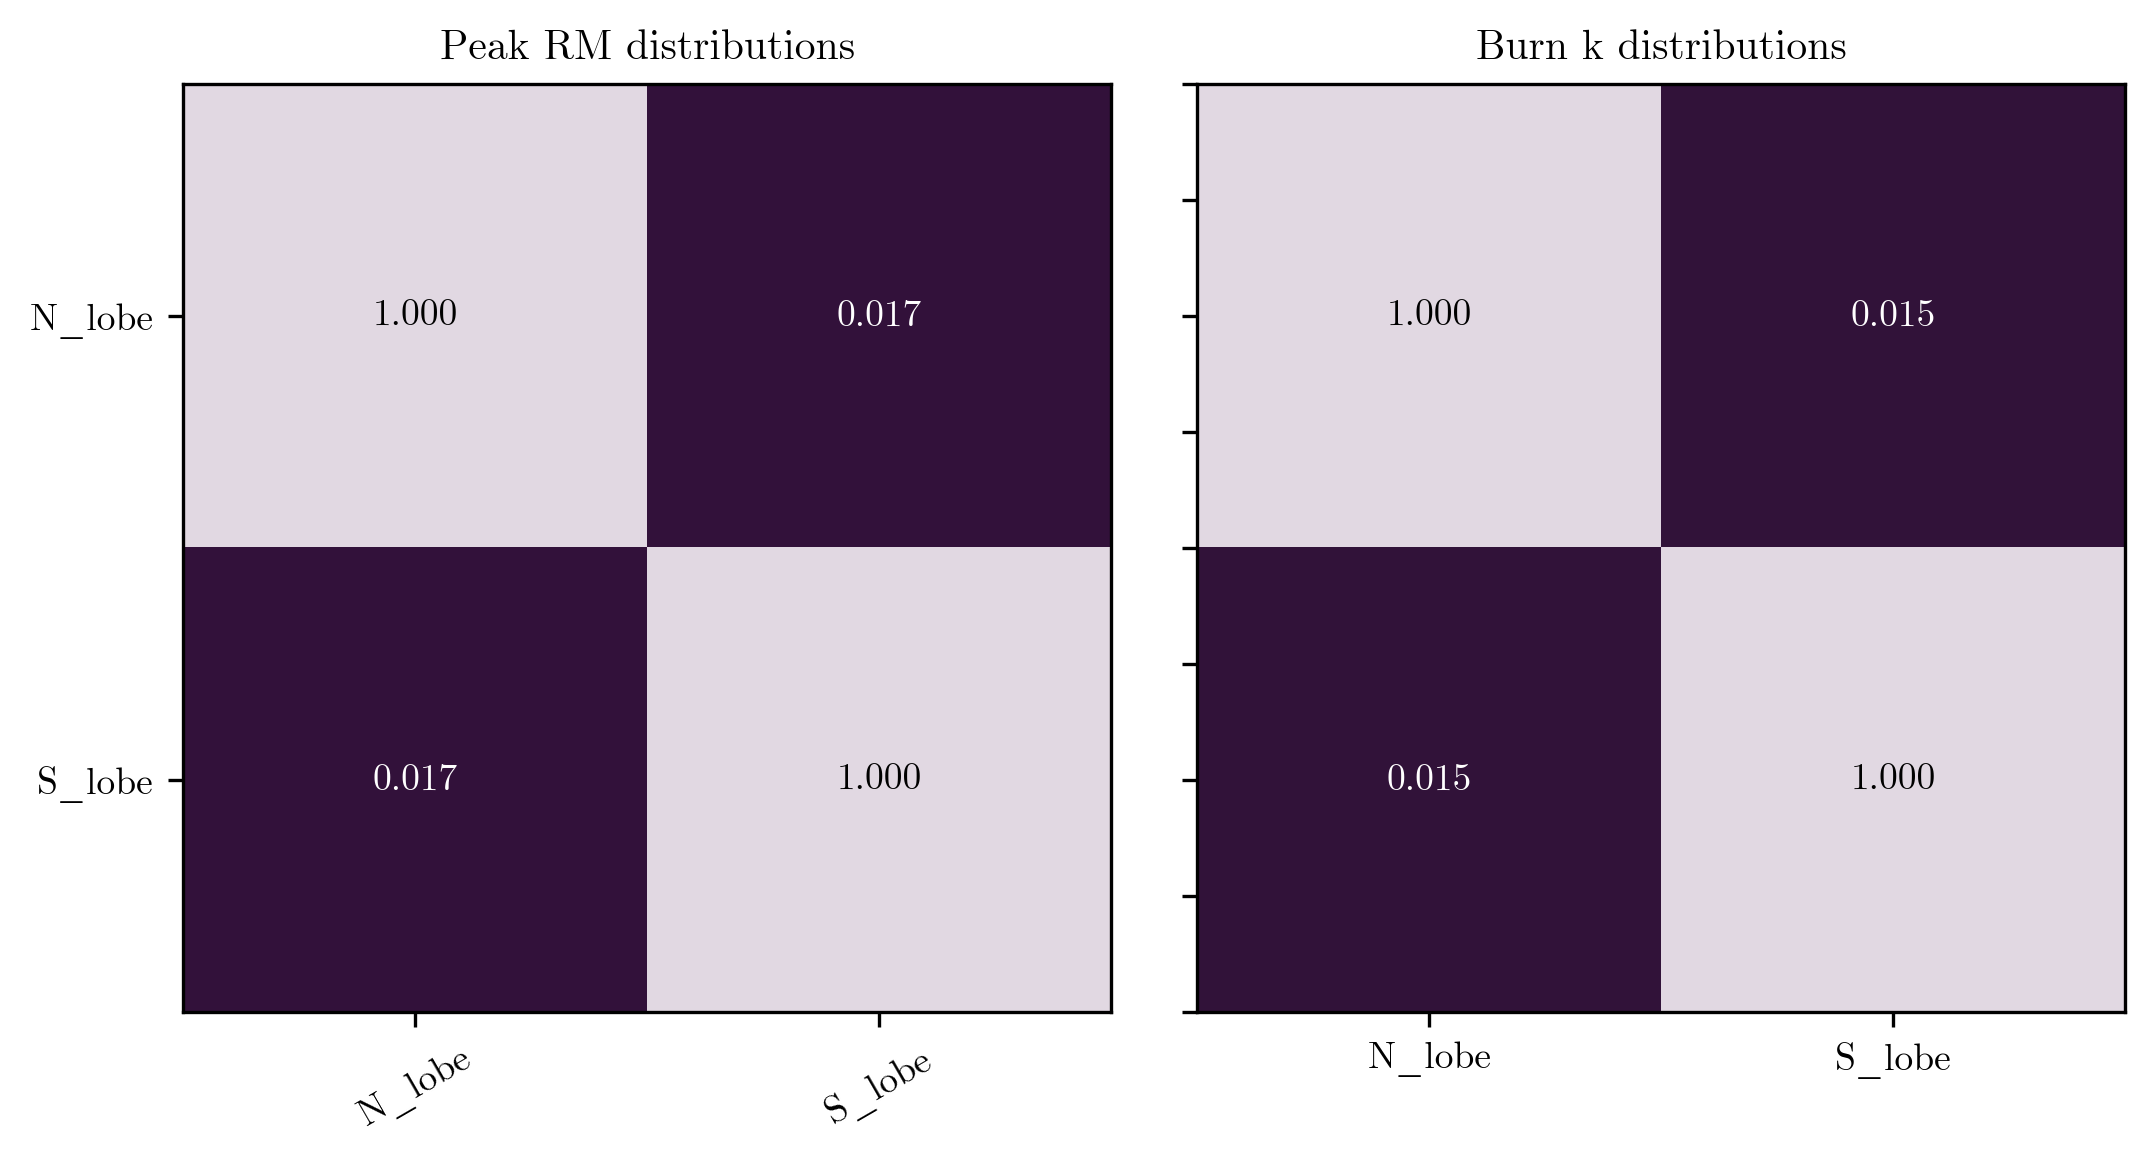

In [9]:
plt.figure(figsize=(8.25,8.25/2),dpi=300)
ax=plt.subplot(121,adjustable='box')
ax.imshow(ks_rm,cmap=tw1,vmin=0,vmax=1)
ticks=np.arange(0,nreg,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,rotation = 30)
ax.set_yticklabels(labels)
ax.set_title('Peak RM distributions')

ax2=plt.subplot(122,adjustable='box')
c=ax2.imshow(ks_k,cmap=tw1,vmin=0,vmax=1)
ax2.set_xticks(ticks)
#ax2.set_yticks(ticks)
ax2.set_xticklabels(labels,rotation = 0)
ax2.set_yticklabels(' ')
ax2.set_title('Burn k distributions')
plt.subplots_adjust(left=0.15, bottom=0.2, right=0.95, top=0.95, wspace=0.05, hspace=0.05)

for i in range(0,nreg):
    for j in range(0,nreg):
        ks_rm[i,j]
        ks_k[i,j]
        if ks_rm[i,j]>=0.4:
            color='k'
        else:
            color='w'
        ax.annotate(text='{:.3f}'.format(ks_rm[i,j]),xy=(i,j),color=color,fontsize=SMALL_SIZE,ha="center",va="center")
        ax2.annotate(text='{:.3f}'.format(ks_k[i,j]),xy=(i,j),color=color,fontsize=SMALL_SIZE,ha="center",va="center")

#plt.savefig(fig_directory+src+'hist_ks.png',dpi=300,transparent=True)
plt.show()

In [10]:
print(ks_rm)
print(ks_k)

[[1.         0.01719976]
 [0.01719976 1.        ]]
[[1.         0.01455762]
 [0.01455762 1.        ]]


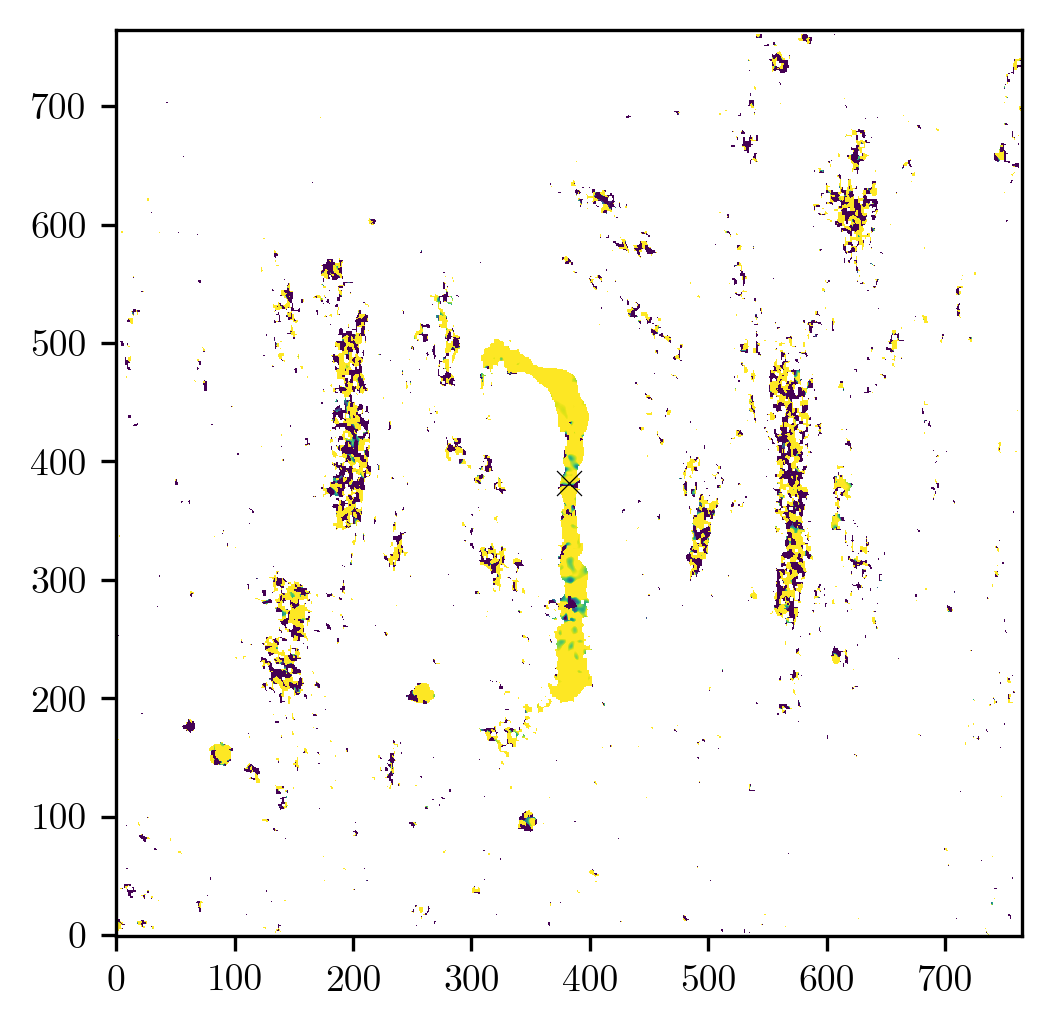

In [11]:
xcoords= np.dstack([np.arange(0,pkRM.shape[1],1)]*pkRM.shape[0])[0,:,:].T
ycoords= np.dstack([np.arange(0,pkRM.shape[0],1)]*pkRM.shape[1])[0,:,:]

xp,yp=utils.skycoord_to_pixel(SkyCoord(ra,dec),wcs)

x_center=xp
y_center=yp
dist=np.sqrt(np.square(xcoords-x_center)+np.square(ycoords-y_center))
ang=np.ndarray.flatten(np.arctan2((ycoords-y_center),(xcoords-x_center)))

plt.figure(dpi=300)
plt.imshow(pkRM,origin='lower',vmin=-50,vmax=50)
plt.scatter(x_center,y_center,marker='x',color='k')
plt.show()

0
1


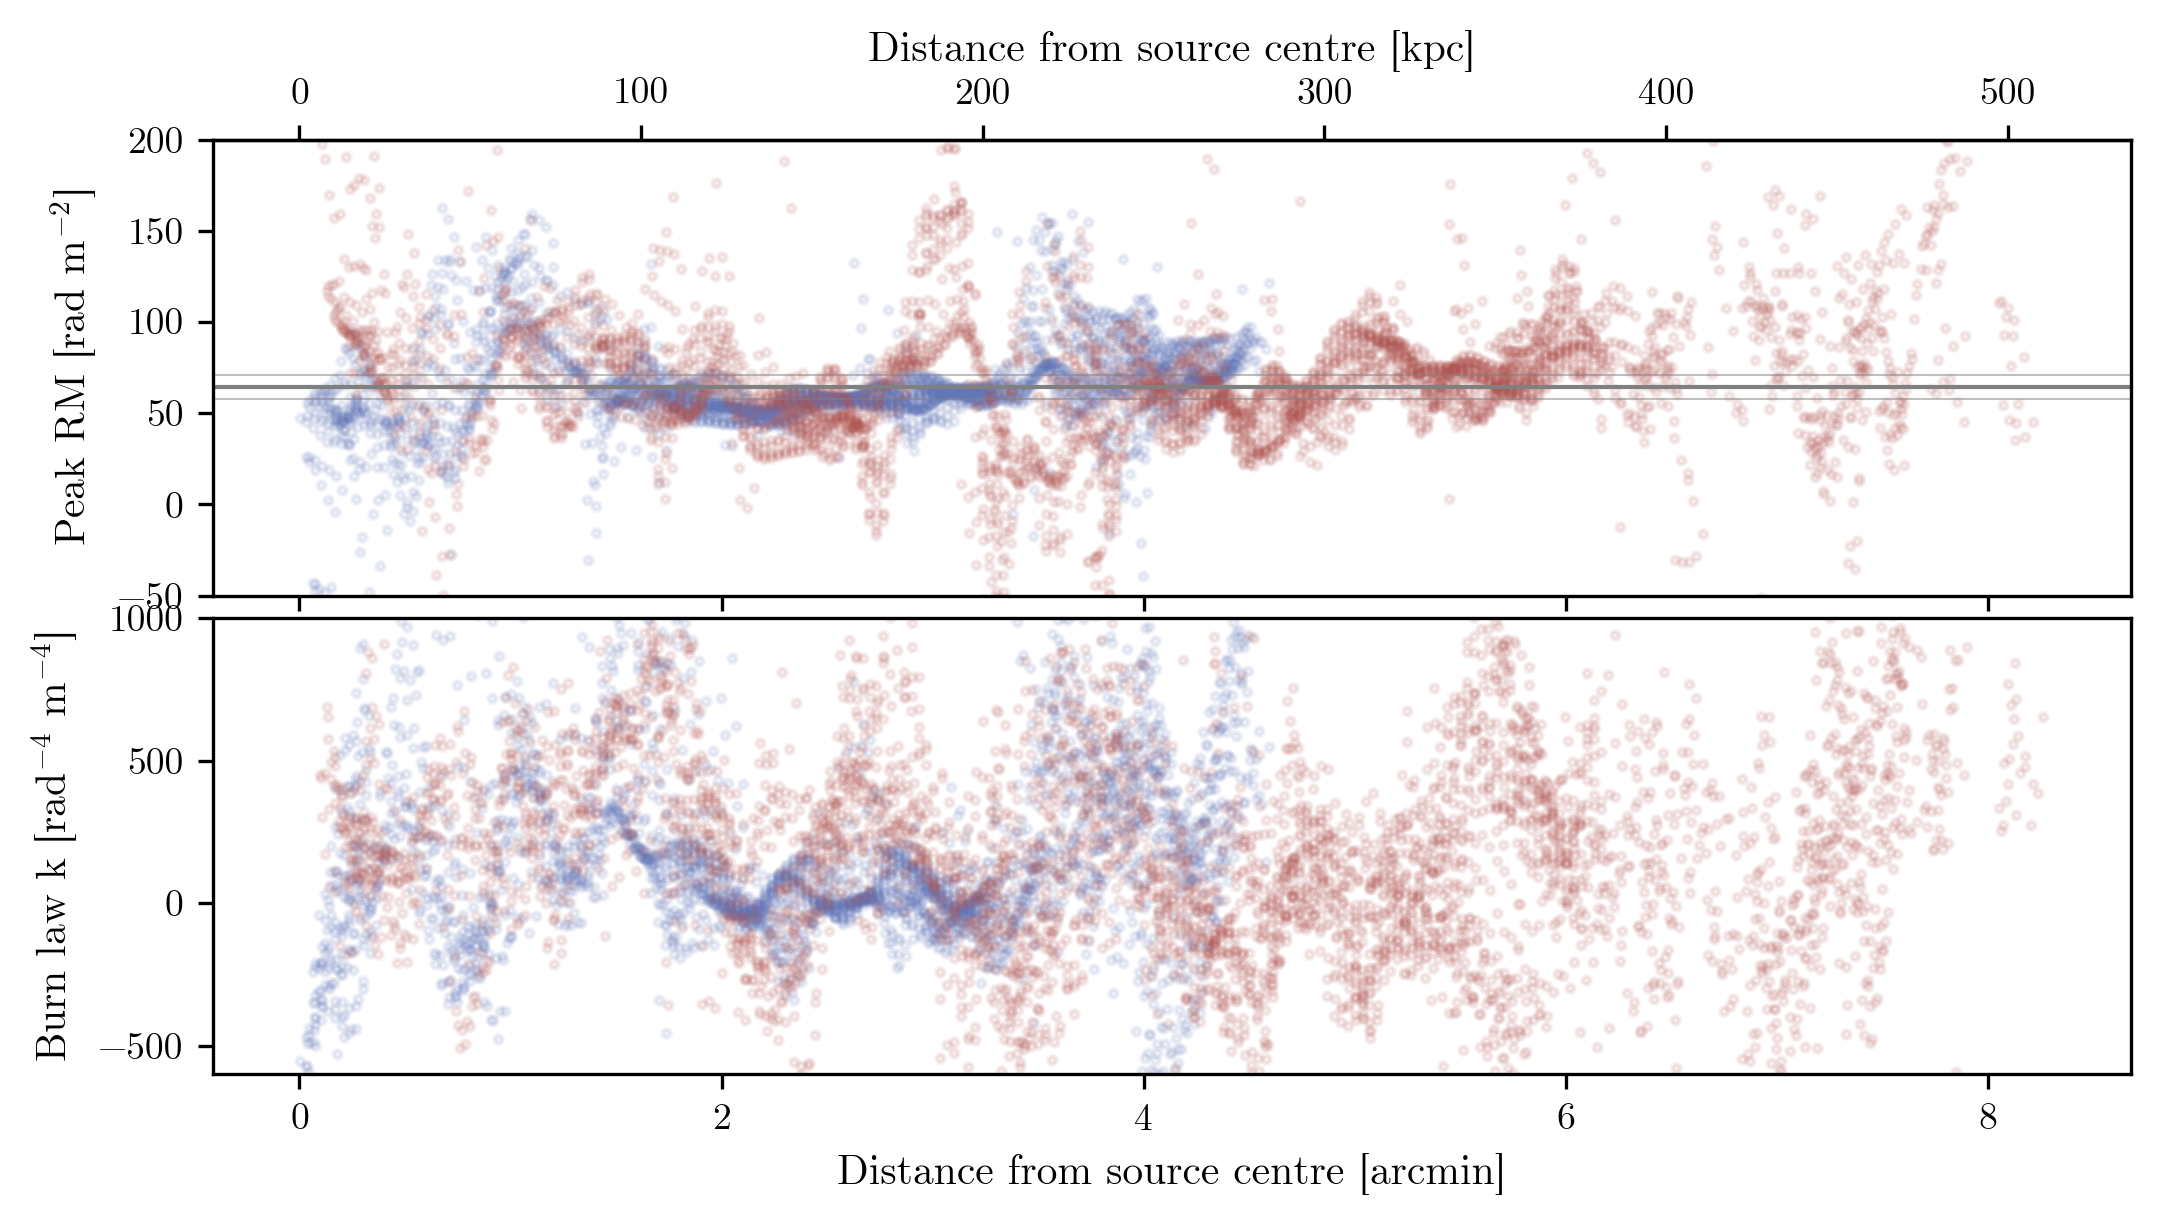

In [12]:
pixscale=pkRMhead['CDELT2']*60 #arcmin
fig=plt.figure(dpi=300,figsize=(8.25,8.25/2))

ax=plt.subplot(211,adjustable='box')
ax2=plt.subplot(212,adjustable='box')

ax.axhline(y=galacticRM,color='grey',lw=1)
ax.axhline(y=galacticRM+gRMerr,color='grey',lw=0.5,alpha=0.5)
ax.axhline(y=galacticRM-gRMerr,color='grey',lw=0.5,alpha=0.5)

for i in range(0,nreg):
    print(i)
    rmflat=np.ndarray.flatten(rm_regions[i,:,:])
    kflat=np.ndarray.flatten(k_regions[i,:,:])
    distflat=np.ndarray.flatten(dist)
    ax.scatter(distflat*pixscale,rmflat,color=twilight(cmapmid[i]),s=4,alpha=0.1,label=labels[i])
    ax2.scatter(distflat*pixscale,kflat,color=twilight(cmapmid[i]),s=4,alpha=0.1,label=labels[i])

ax.set_ylim(rm_min,rm_max)
ax.set_xticklabels([])
#ax.set_xlim(0,12)
#ax2.set_xlim(0,12)
ax.set_ylabel(r'Peak RM [rad m$^{-2}$]')
ax2.set_ylabel(r'Burn law k [rad$^{-4}$ m$^{-4}$]')
ax2.set_xlabel('Distance from source centre [arcmin]')
ax2.set_ylim(burn_min,burn_max)
#plt.legend()

if z is not None:   
    secax = ax.secondary_xaxis('top', functions=(arcsectokpc, kpctoarcsec))
    secax.set_xlabel('Distance from source centre [kpc]')

plt.subplots_adjust(wspace=0, hspace=0.05)
#plt.savefig(fig_directory+src+'rm_dist_sepreg.png',dpi=300,transparent=True)
plt.show()

0
1


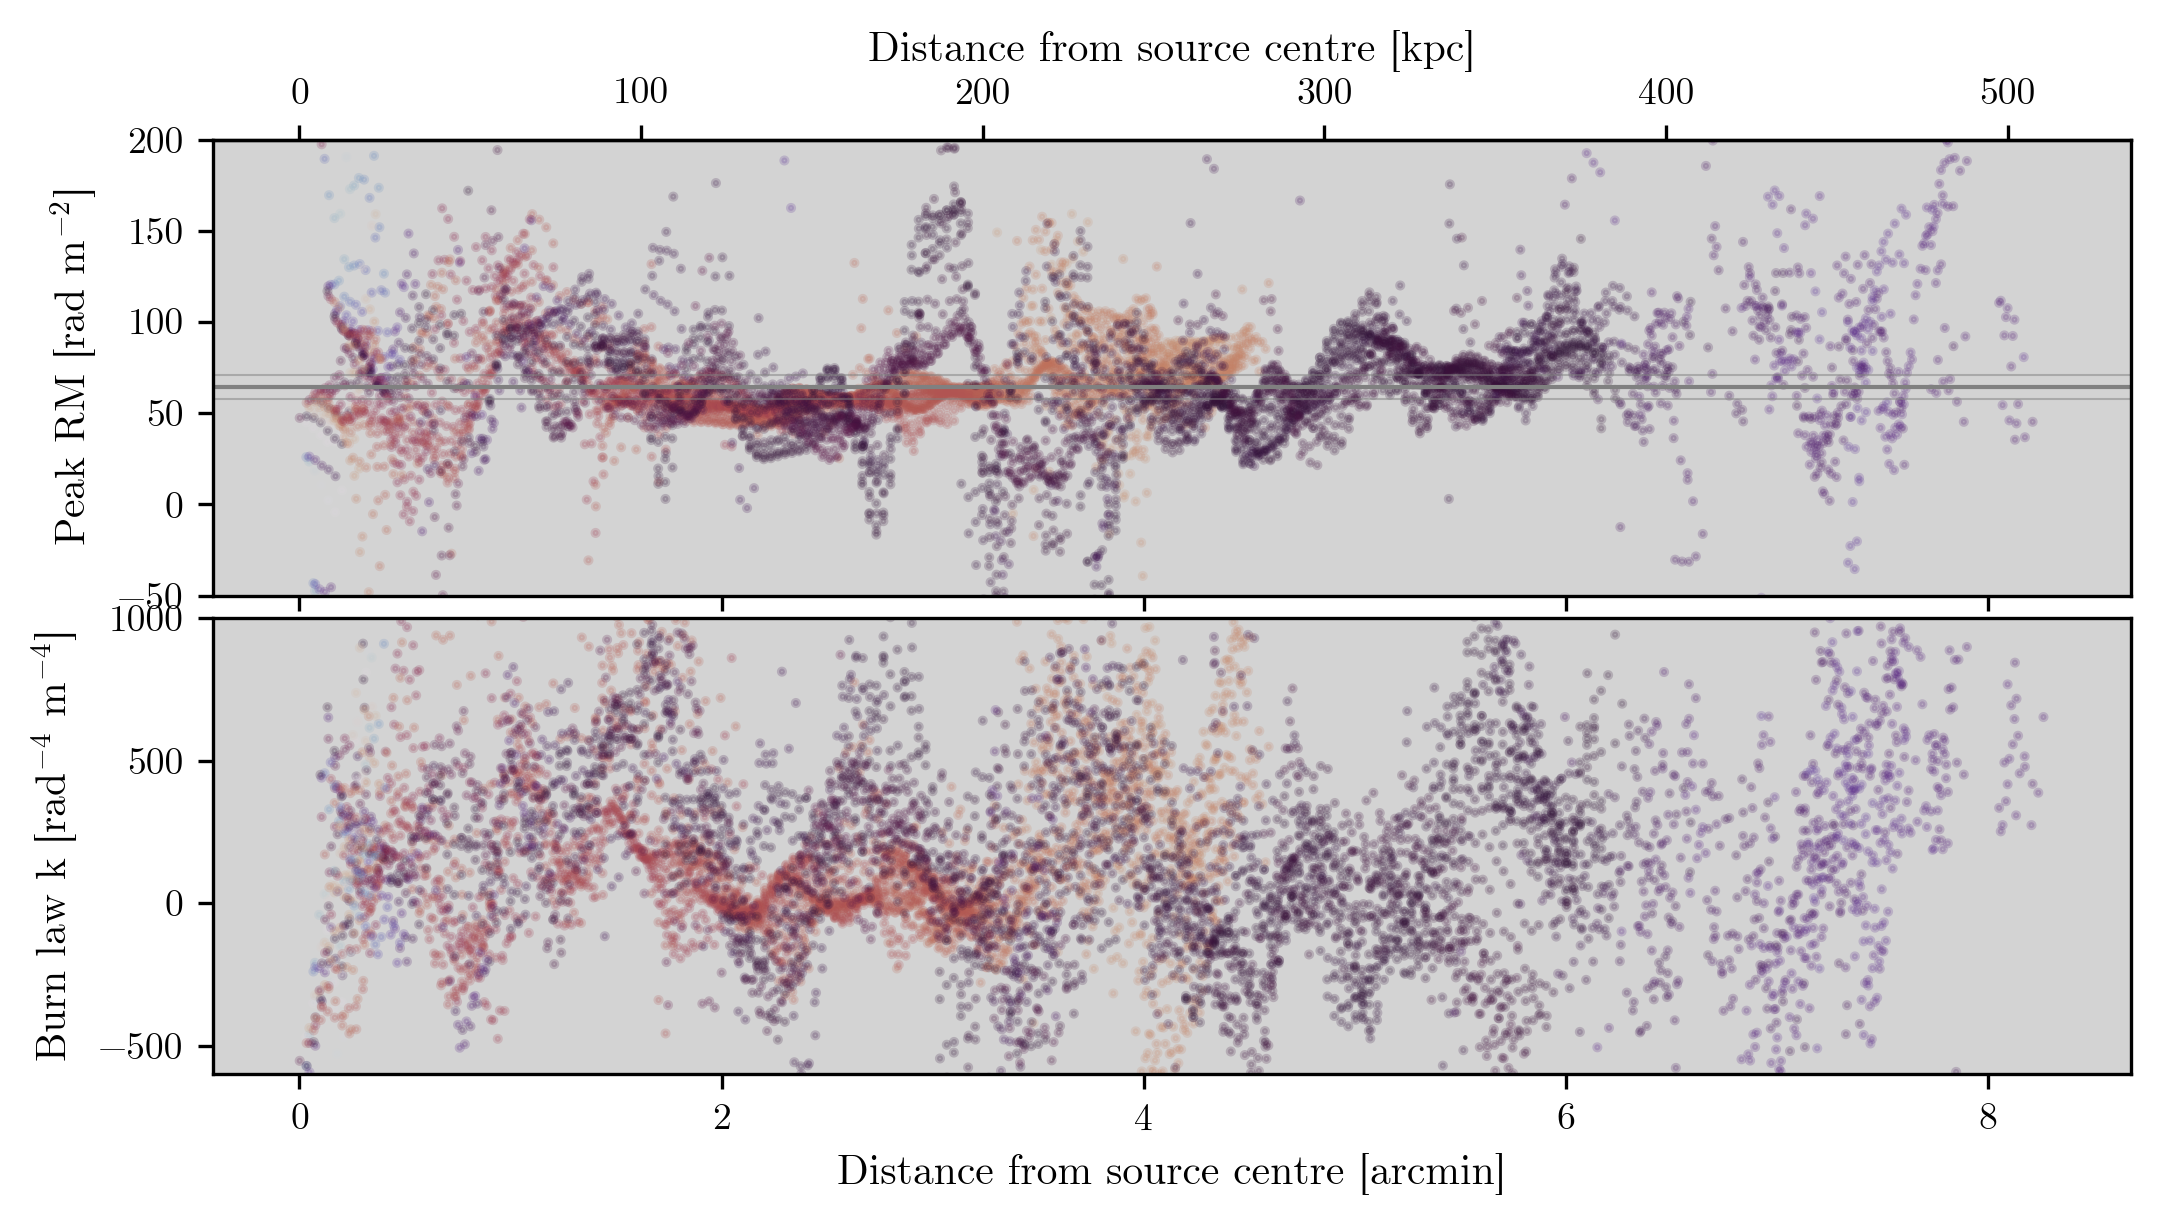

In [13]:
pixscale=pkRMhead['CDELT2']*60 #arcmin


fig=plt.figure(dpi=300,figsize=(8.25,8.25/2))

ax=plt.subplot(211,adjustable='box')
ax2=plt.subplot(212,adjustable='box')

ax.axhline(y=galacticRM,color='grey',lw=1)
ax.axhline(y=galacticRM+gRMerr,color='grey',lw=0.5,alpha=0.5)
ax.axhline(y=galacticRM-gRMerr,color='grey',lw=0.5,alpha=0.5)

for i in range(0,nreg):
    print(i)
    rmflat=np.ndarray.flatten(rm_regions[i,:,:])
    kflat=np.ndarray.flatten(k_regions[i,:,:])
    distflat=np.ndarray.flatten(dist)
    ax.scatter(distflat*pixscale,rmflat,c=ang,cmap=twilight,s=2,alpha=0.2,label=labels[i])
    ax2.scatter(distflat*pixscale,kflat,c=ang,cmap=twilight,s=2,alpha=0.2,label=labels[i])

ax.set_facecolor("lightgrey")
ax2.set_facecolor("lightgrey")
ax.set_ylim(rm_min,rm_max)
ax.set_xticklabels([])
#ax.set_xlim(0,12)
#ax2.set_xlim(0,12)
ax.set_ylabel(r'Peak RM [rad m$^{-2}$]')
ax2.set_ylabel(r'Burn law k [rad$^{-4}$ m$^{-4}$]')
ax2.set_xlabel('Distance from source centre [arcmin]')
ax2.set_ylim(burn_min,burn_max)
#plt.legend()

if z is not None:   
    secax = ax.secondary_xaxis('top', functions=(arcsectokpc, kpctoarcsec))
    secax.set_xlabel('Distance from source centre [kpc]')

plt.subplots_adjust(wspace=0, hspace=0.05)
#plt.savefig(fig_directory+src+'rm_dist_ang.png',dpi=300,transparent=True)
    

In [14]:
if src=='2018-5540': 
    fig=plt.figure(dpi=300,figsize=(8.25,8.25))

    ax=plt.subplot(411,adjustable='box')
    ax2=plt.subplot(412,adjustable='box')
    ax3=plt.subplot(413,adjustable='box')
    ax4=plt.subplot(414,adjustable='box')

    distflat=np.ndarray.flatten(dist)

    i=0
    rmflat=np.ndarray.flatten(rm_regions[i,:,:])
    ax.scatter(distflat*pixscale,rmflat,color=twilight(cmapmid[i]),s=4,alpha=0.05,label=labels[i])
    ax.annotate(text=labels[i],xy=(0.1,0.91),xycoords='figure fraction',color='k',fontsize=SMALL_SIZE)
    i=1
    rmflat=np.ndarray.flatten(rm_regions[i,:,:])
    ax2.scatter(distflat*pixscale,rmflat,color=twilight(cmapmid[i]),s=4,alpha=0.05,label=labels[i])
    ax2.annotate(text=labels[i],xy=(0.1,0.69),xycoords='figure fraction',color='k',fontsize=SMALL_SIZE)
    i=3
    rmflat=np.ndarray.flatten(rm_regions[i,:,:])
    ax3.scatter(distflat*pixscale,rmflat,color=twilight(cmapmid[i]),s=4,alpha=0.05,label=labels[i])
    ax3.annotate(text=labels[i],xy=(0.1,0.47),xycoords='figure fraction',color='k',fontsize=SMALL_SIZE)
    i=4
    rmflat=np.ndarray.flatten(rm_regions[i,:,:])
    ax4.scatter(distflat*pixscale,rmflat,color=twilight(cmapmid[i]),s=4,alpha=0.05,label=labels[i])
    ax4.annotate(text=labels[i],xy=(0.1,0.25),xycoords='figure fraction',color='k',fontsize=SMALL_SIZE)



    ax.set_ylim(rm_min,rm_max)
    ax2.set_ylim(rm_min,rm_max)
    ax3.set_ylim(rm_min,rm_max)
    ax4.set_ylim(rm_min,rm_max)
    ax.set_xticklabels([])
    ax2.set_xticklabels([])
    ax3.set_xticklabels([])
    ax.set_ylabel(r'Peak RM [rad m$^{-2}$]')
    ax2.set_ylabel(r'Peak RM [rad m$^{-2}$]')
    ax3.set_ylabel(r'Peak RM [rad m$^{-2}$]')
    ax4.set_ylabel(r'Peak RM [rad m$^{-2}$]')
    ax4.set_xlabel('Distance from source centre [arcmin]')
    #plt.legend()
    ax.set_xlim(0,12)
    ax2.set_xlim(0,12)
    ax3.set_xlim(0,12)
    ax4.set_xlim(0,12)
    plt.subplots_adjust(wspace=0, hspace=0.1)
    #plt.savefig(fig_directory+src+'rm_dist_sepreg2.png',dpi=300,transparent=True)
    plt.show()

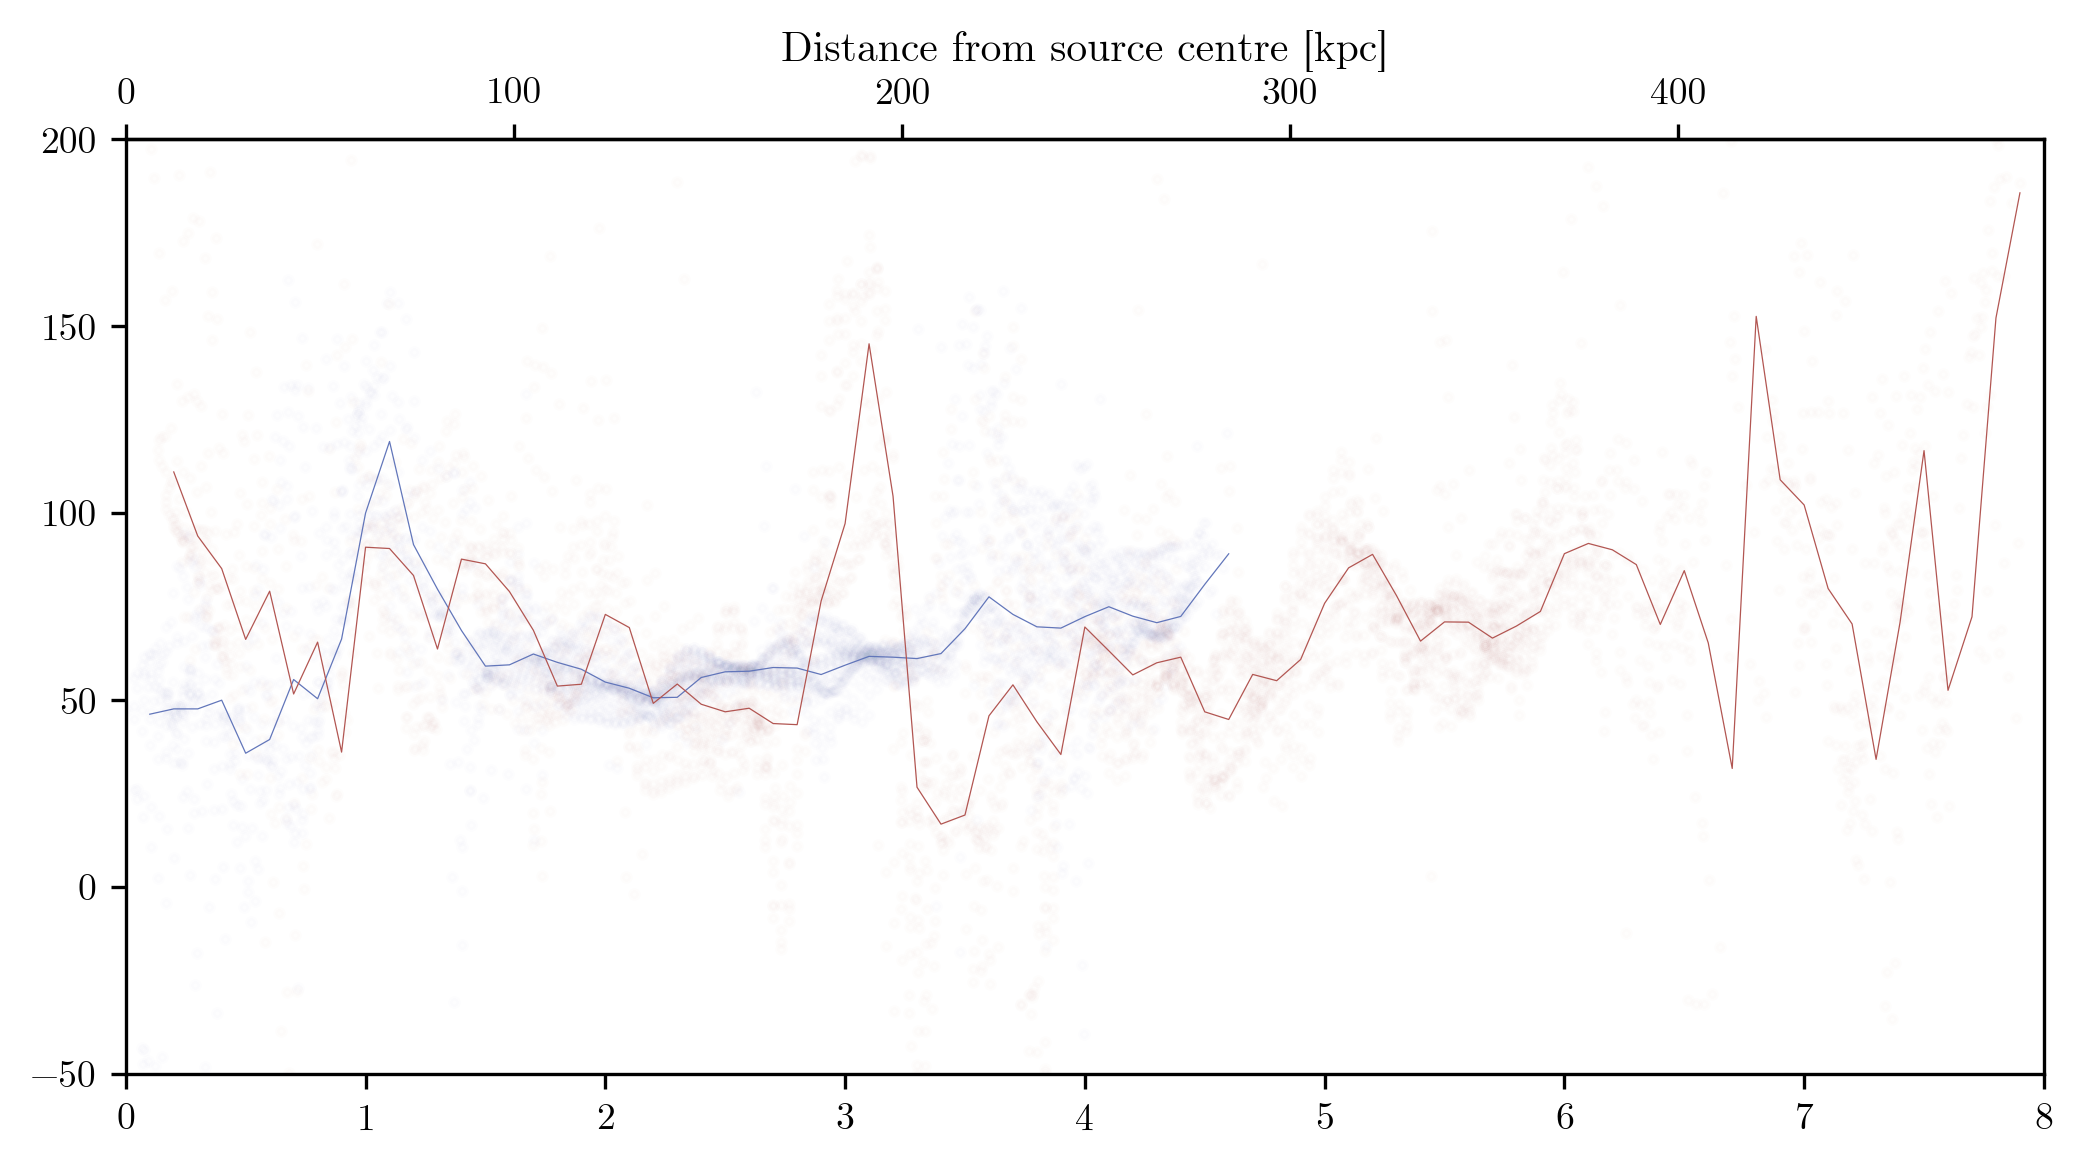

In [15]:
dsort=np.argsort(distflat)

x=distflat[dsort]*pixscale
y=np.ndarray.flatten(rm_regions[0,:,:])[dsort]
y2=np.ndarray.flatten(rm_regions[1,:,:])[dsort]

x=x[np.where(np.isfinite(y))]
y=y[np.where(np.isfinite(y))]

x2=distflat[dsort]*pixscale
x2=x2[np.where(np.isfinite(y2))]
y2=y2[np.where(np.isfinite(y2))]


plt.figure(dpi=300,figsize=(8.25,8.25/2))
ax=plt.subplot(111,adjustable='box')
#TODO: data binning and FTT
bins=np.arange(0,12,0.1)
inds=np.digitize(x, bins)
inds2=np.digitize(x2, bins)

avRM=np.empty(shape=bins.shape)
stdRM=np.empty(shape=bins.shape)
n=np.empty(shape=bins.shape)

avRM2=np.empty(shape=bins.shape)
stdRM2=np.empty(shape=bins.shape)
n2=np.empty(shape=bins.shape)

avRMboth=np.empty(shape=bins.shape)
stdRMboth=np.empty(shape=bins.shape)

for i in range (0,len(bins)):
    locs=np.where(inds==i,1,0)
    locs2=np.where(inds2==i,1,0)
    n=np.sum(locs)
    n2=np.sum(locs2)
    y_sub=np.where(inds==i,y,np.nan)
    y2_sub=np.where(inds2==i,y2,np.nan)
    if n>=3:
        avRM[i]=np.nanmedian(y_sub)
        stdRM[i]=np.nanstd(y_sub)/np.sqrt(np.sum(locs))
    else:
        avRM[i]=np.nan
        stdRM[i]=np.nan
    if n2>=3:
        avRM2[i]=np.nanmedian(y2_sub)
        stdRM2[i]=np.nanstd(y2_sub)/np.sqrt(np.sum(locs2))
    else:
        avRM2[i]=np.nan
        stdRM2[i]=np.nan
        
    if n+n2>=3:
        avRMboth[i]=np.nanmedian(np.concatenate((y_sub,y2_sub)))
        stdRMboth[i]=np.nanstd(np.concatenate((y_sub,y2_sub)))/(np.sqrt(n+n2))

ax.plot(bins,avRM,color=twilight(cmapmid[0]))
#ax.errorbar(bins,avRM,stdRM,color=twilight(cmapmid[0]))
rmflat=np.ndarray.flatten(rm_regions[0,:,:])
ax.scatter(distflat*pixscale,rmflat,color=twilight(cmapmid[0]),s=4,alpha=0.01,label=labels[0])

ax.plot(bins,avRM2,color=twilight(cmapmid[1]))
#ax.errorbar(bins,avRM2,stdRM2,color=twilight(cmapmid[1]))
rmflat=np.ndarray.flatten(rm_regions[1,:,:])
ax.scatter(distflat*pixscale,rmflat,color=twilight(cmapmid[1]),s=4,alpha=0.01,label=labels[1])


#ax.errorbar(bins,avRMboth,stdRMboth,color='k')



ax.set_ylim(rm_min,rm_max)
secax = ax.secondary_xaxis('top', functions=(arcsectokpc, kpctoarcsec))
secax.set_xlabel('Distance from source centre [kpc]')
ax.set_xlim(0,8)
plt.show()
    

[  0   1  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119]


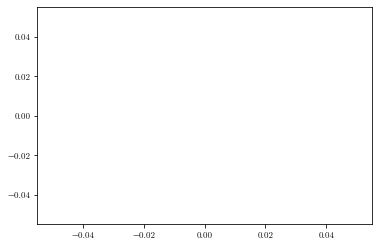

In [16]:
from scipy.fft import fft, ifft
av=0.5*np.add(avRM,avRM2)
nans=np.where(np.isnan(av))[0]
print(nans)
ffteeb=fft(av[3:116])
plt.plot(ffteeb)
plt.show()

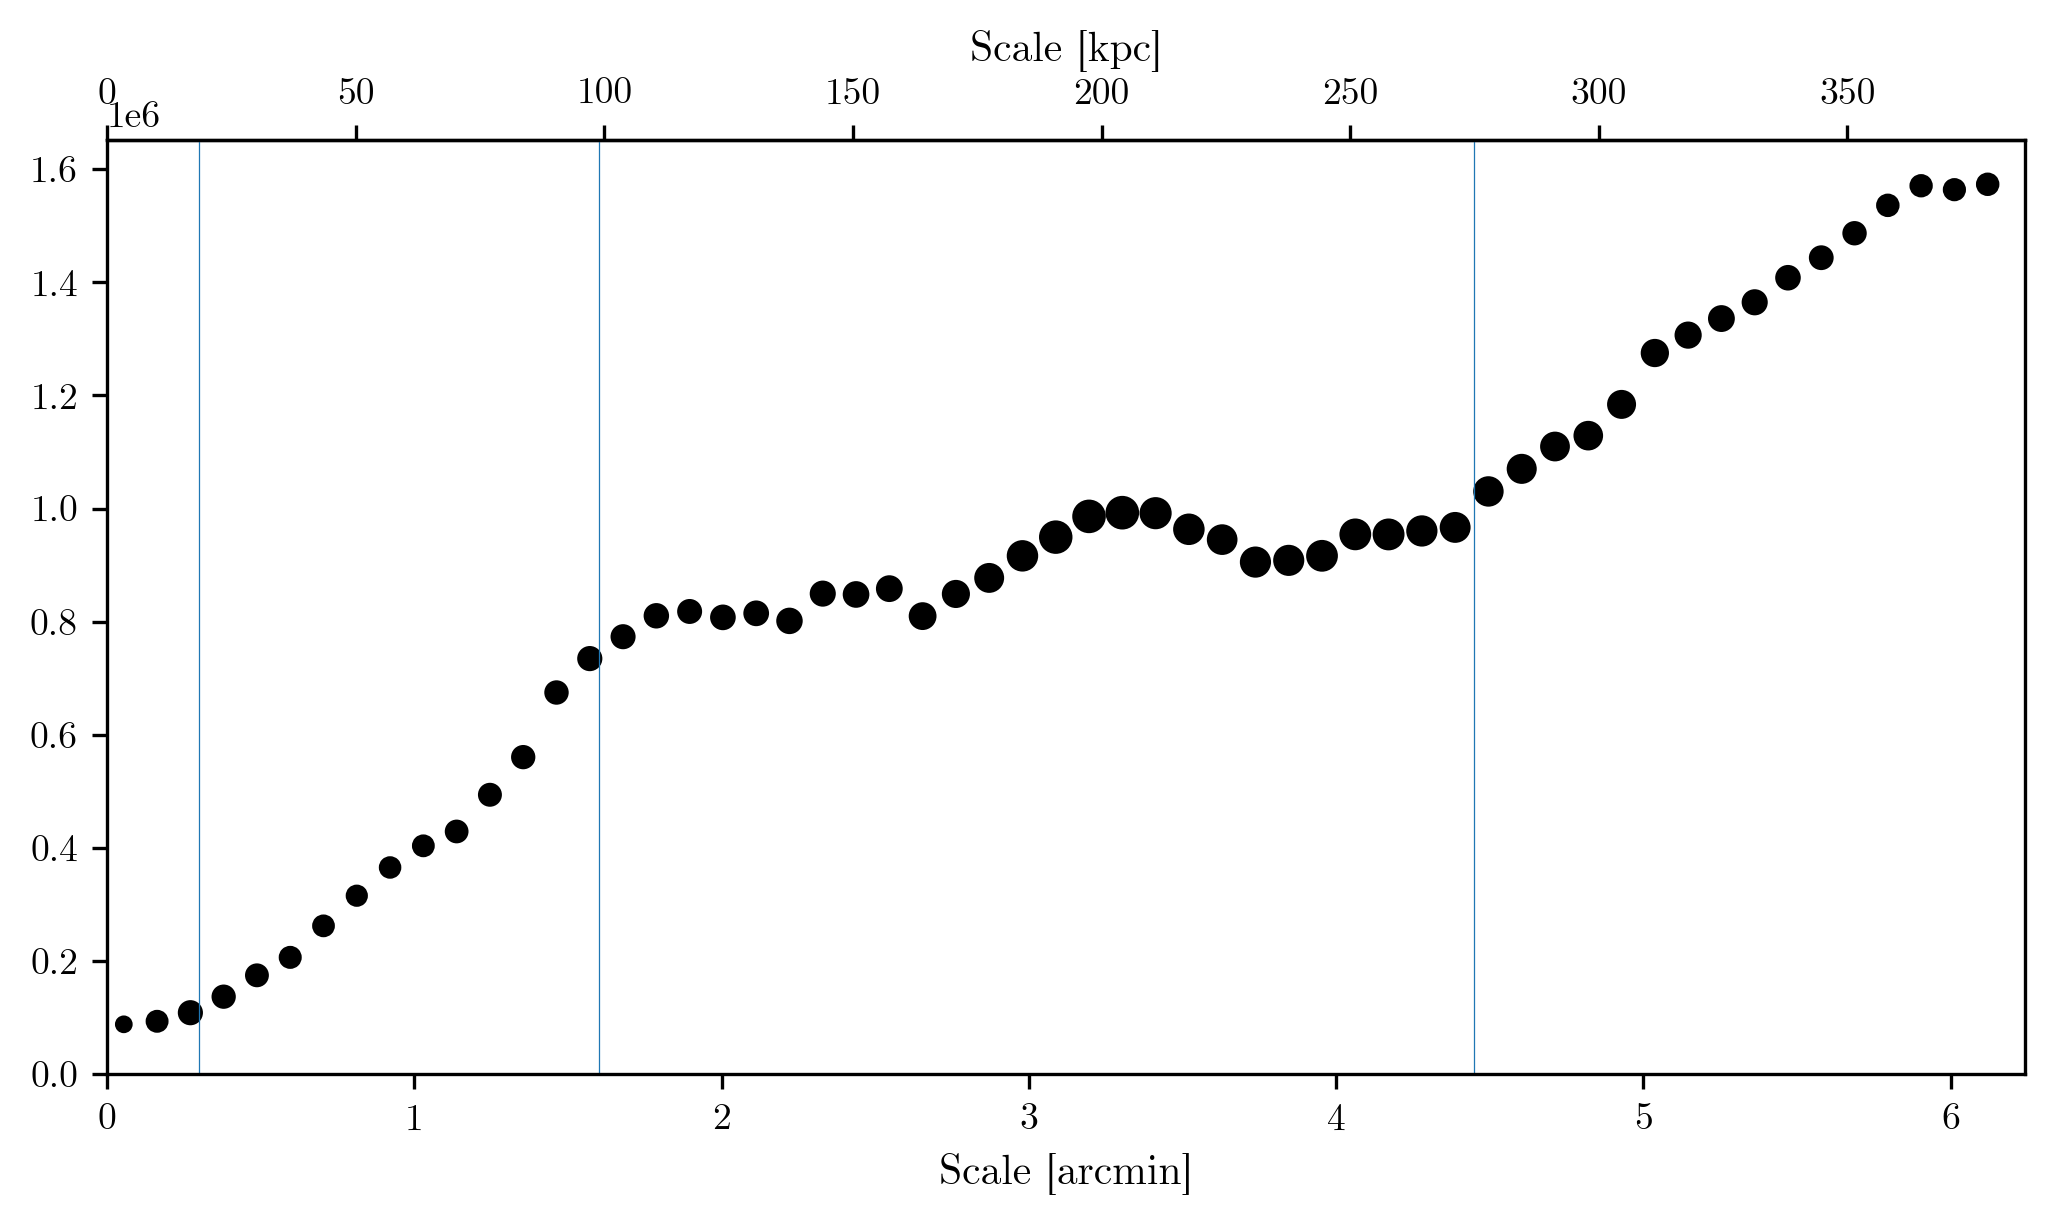

In [17]:
SF=np.loadtxt(rootdirectory+src+'/'+src+'_RM_SF.txt')
arcmins=SF[0,:]/60.
markersizes=50*SF[3,:]/np.nanmax(SF[3,:])
color='k'
plt.figure(dpi=300,figsize=(8.25,8.25/2))
ax=plt.subplot(111,adjustable='box')
ax.scatter(arcmins,SF[1,:],marker='o',s=markersizes,color=color,label=src)
#plt.plot(arcmins,SF[1,:],color=color)
ax.errorbar(arcmins,SF[1,:],SF[2,:],color=color,linestyle='none')
ax.set_xlabel('Scale [arcmin]')
secax = ax.secondary_xaxis('top', functions=(arcsectokpc, kpctoarcsec))
secax.set_xlabel('Scale [kpc]')
ax.set_xlim(0,1.02*np.nanmax(arcmins))
ax.set_ylim(0,1.05*np.nanmax(SF[1,:]))
ax.axvline(x=0.3)
ax.axvline(x=1.6)
ax.axvline(x=4.45)

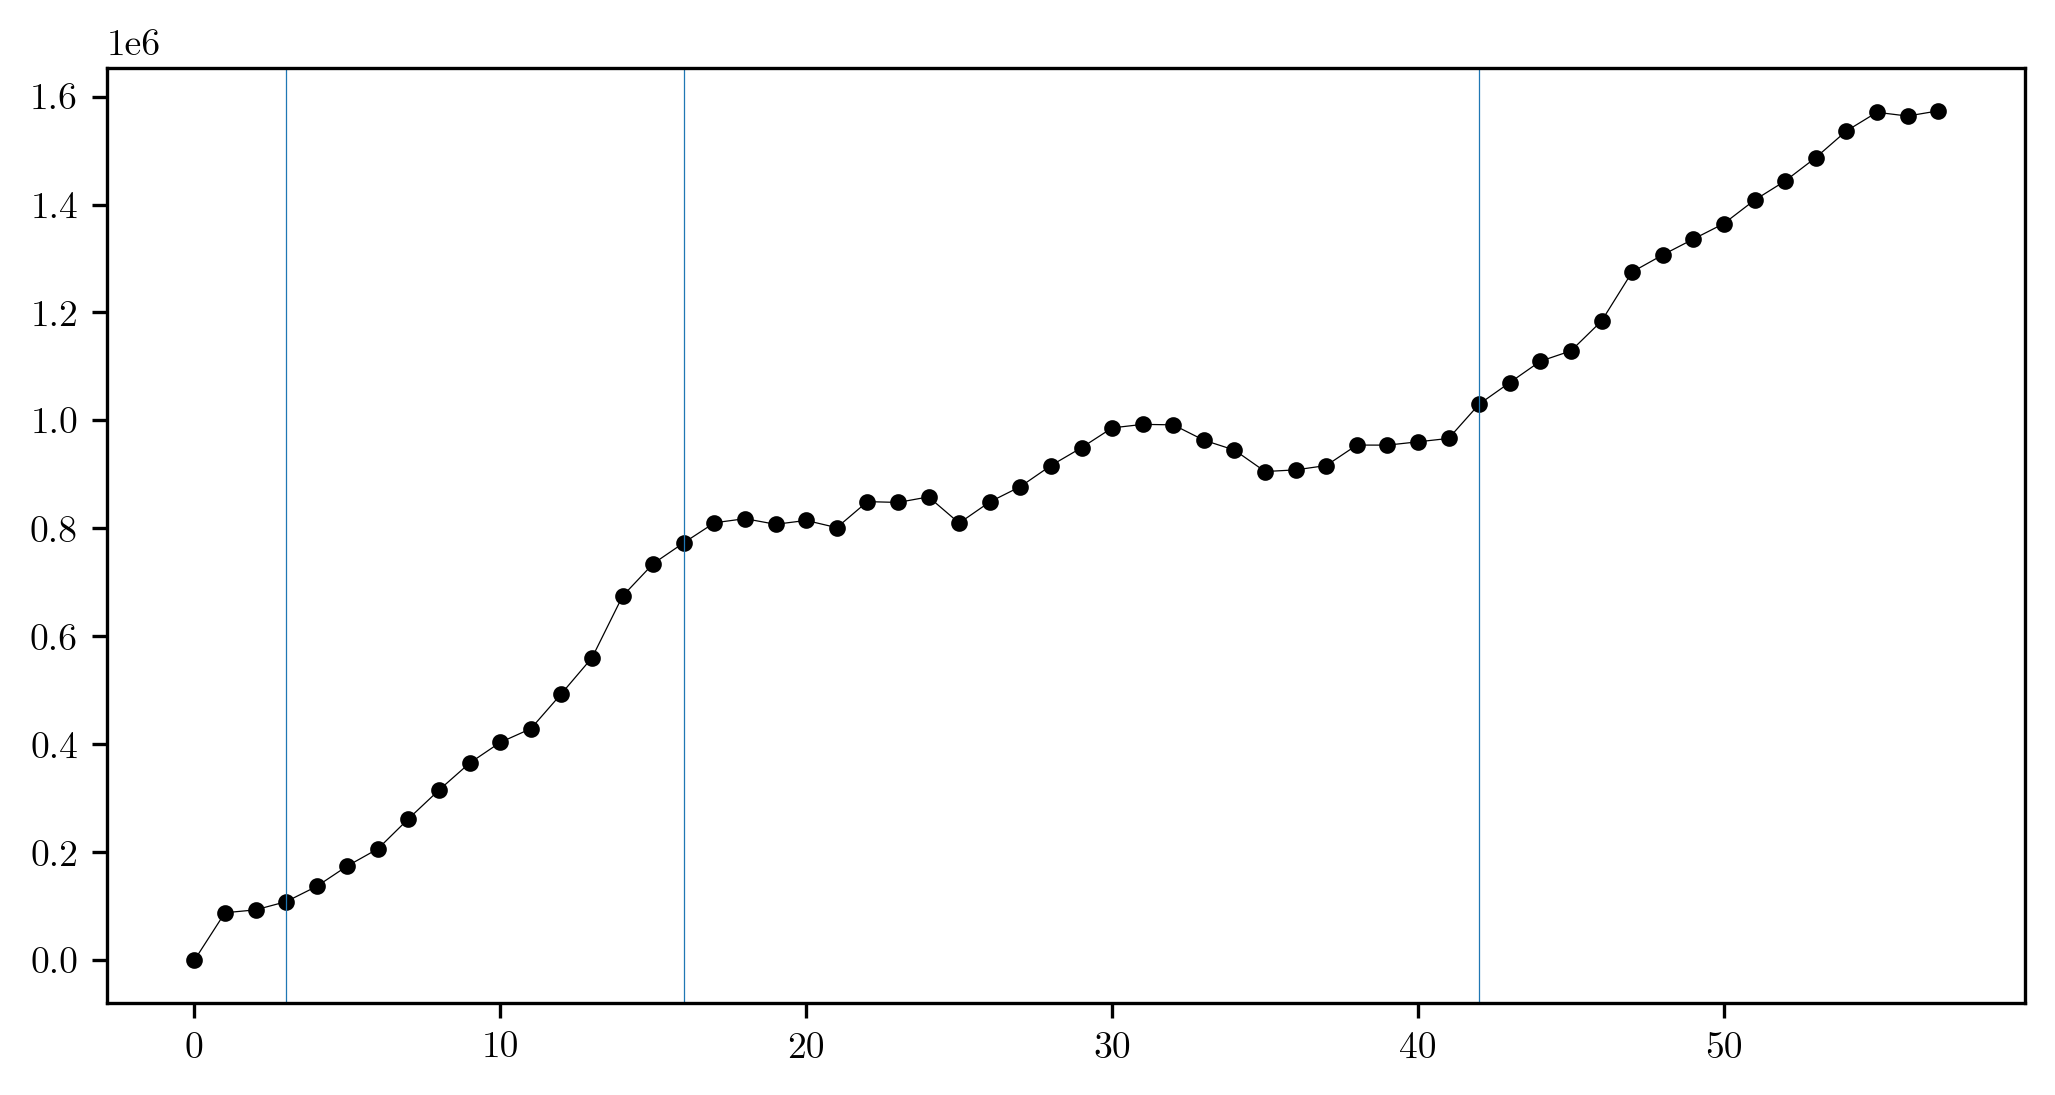

In [18]:
plt.figure(dpi=300,figsize=(8.25,8.25/2))
ax=plt.subplot(111,adjustable='box')
#ax.scatter(arcmins,SF[1,:],marker='o',s=markersizes,color=color,label=src)
ax.plot(SF[1,:],color=color,marker='.')
ax.axvline(x=42)
ax.axvline(x=16)
ax.axvline(x=3)

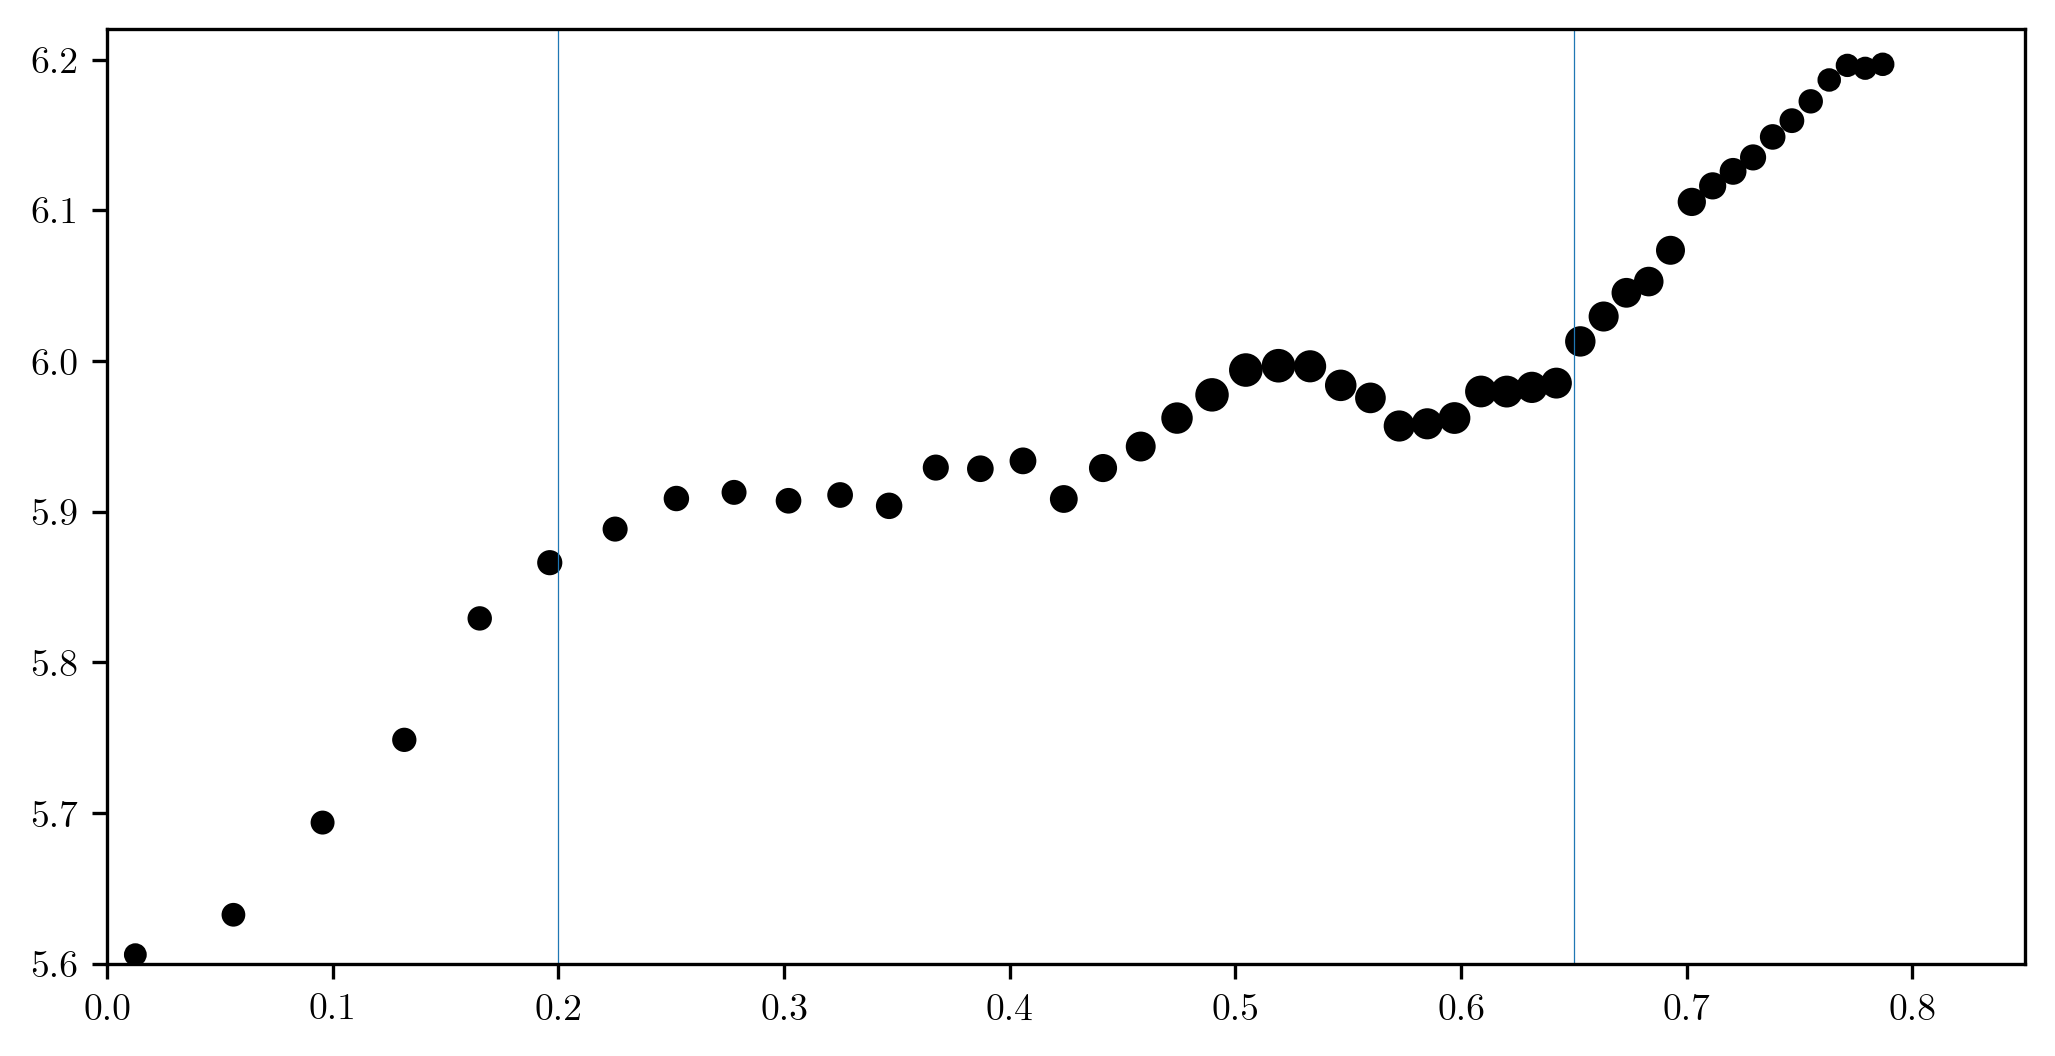

In [19]:
plt.figure(dpi=300,figsize=(8.25,8.25/2))
ax=plt.subplot(111,adjustable='box')
ax.scatter(np.log10(arcmins),np.log10(SF[1,:]),marker='o',s=markersizes,color=color,label=src)
ax.set_xlim(0,0.85)
ax.set_ylim(5.6,6.22)
ax.axvline(x=0.2)
ax.axvline(x=0.65)


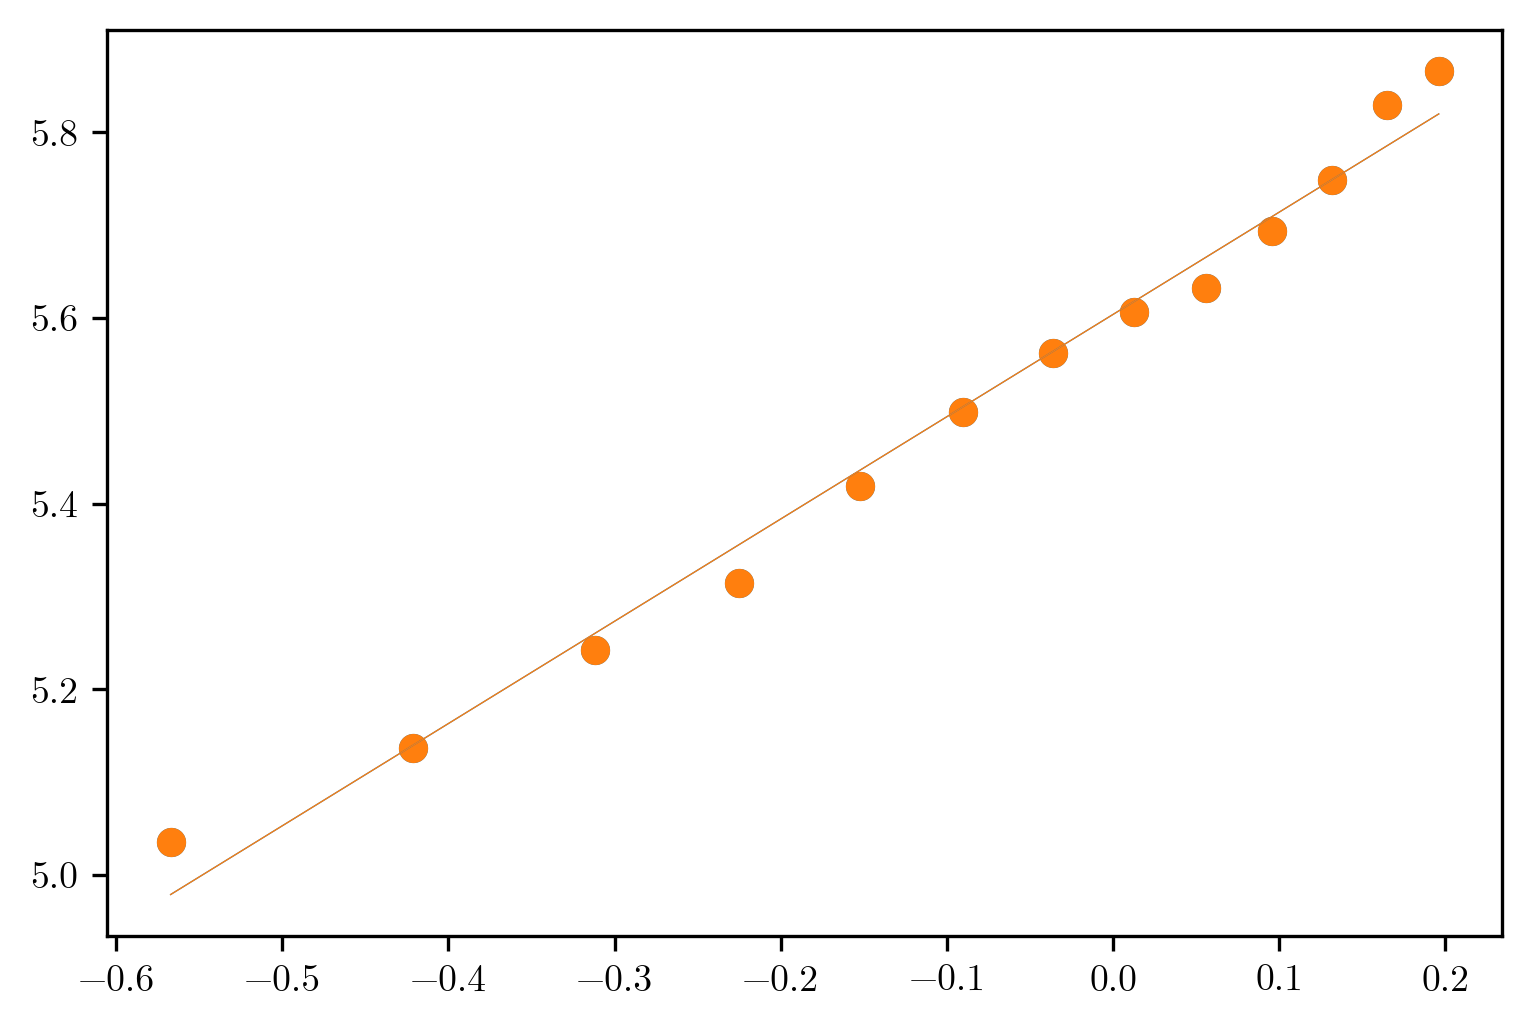

<module 'math' from '/Users/emma/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload/math.cpython-39-darwin.so'> AxesImage(1404.26,247.5;928.125x928.125)


In [20]:
smallscales=np.log10(arcmins[3:16])
scSF=np.log10(SF[1,3:16])

plt.figure(dpi=300)
plt.scatter(smallscales,scSF)

sm,sc=np.polyfit(smallscales,scSF,1)
plt.plot(smallscales,sm*smallscales+sc)
plt.scatter(smallscales,scSF)
sm,sc=np.polyfit(smallscales,scSF,1)
plt.plot(smallscales,sm*smallscales+sc)
plt.show()
print(m,c)

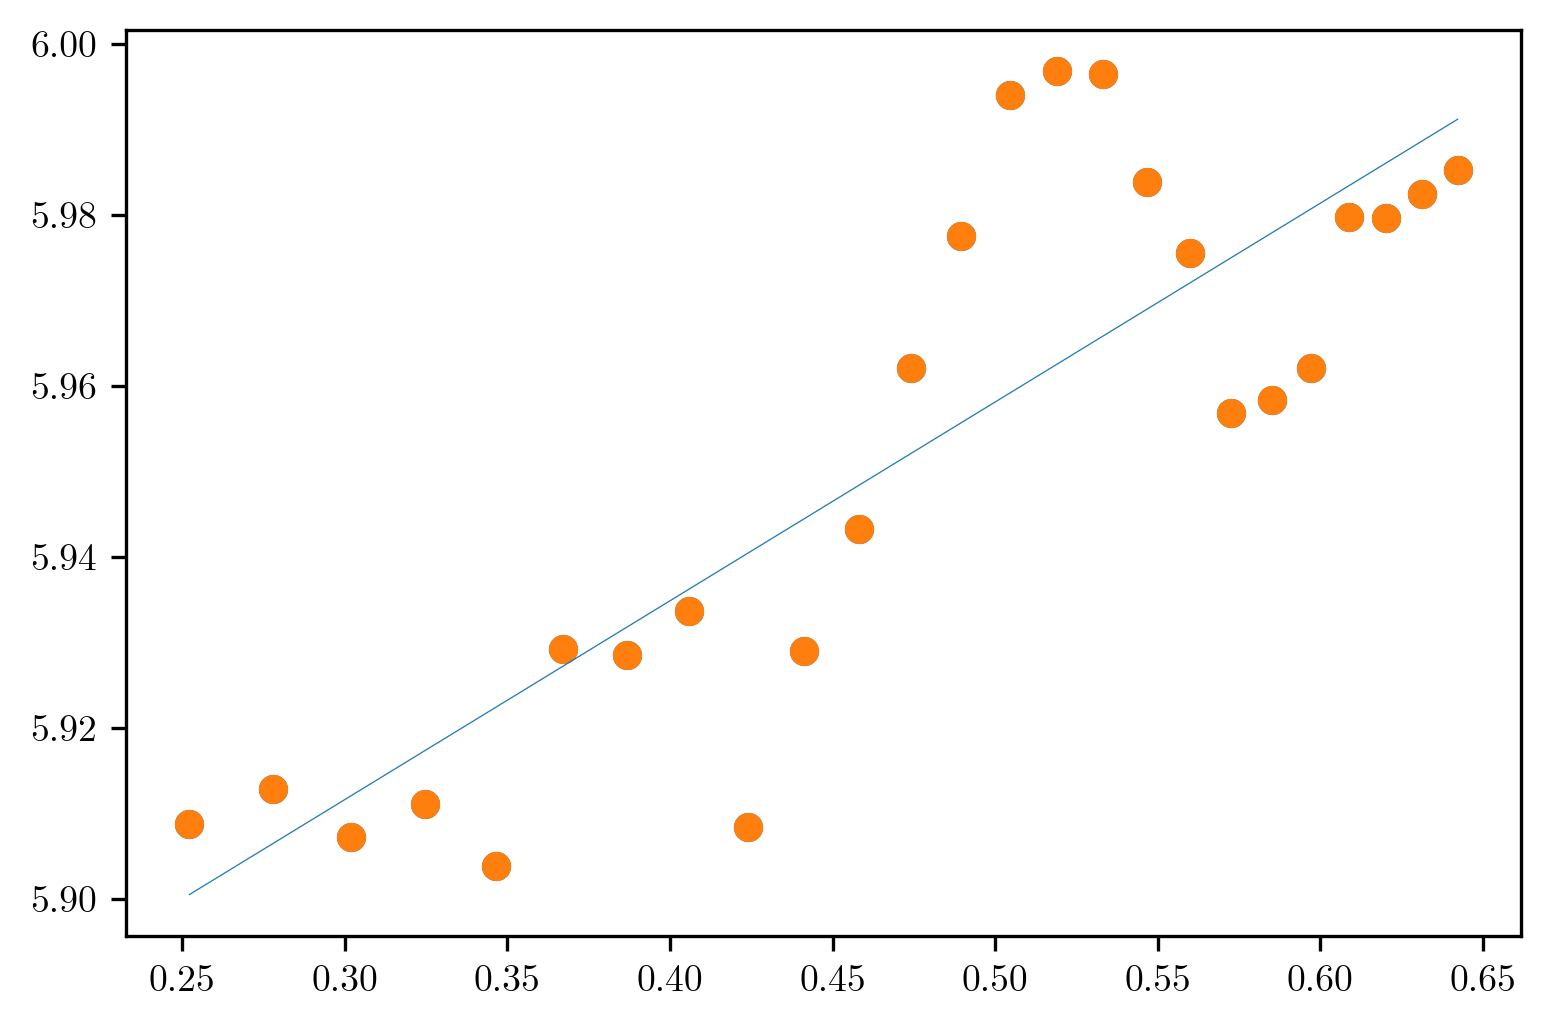

0.23258197450559265 5.841813473103694


In [21]:
mscales=np.log10(arcmins[17:42])
mSF=np.log10(SF[1,17:42])

plt.figure(dpi=300)
plt.scatter(mscales,mSF)
mm,mc=np.polyfit(mscales,mSF,1)
plt.plot(mscales,mm*mscales+mc)
plt.scatter(mscales,mSF)
plt.show()
print(mm,mc)

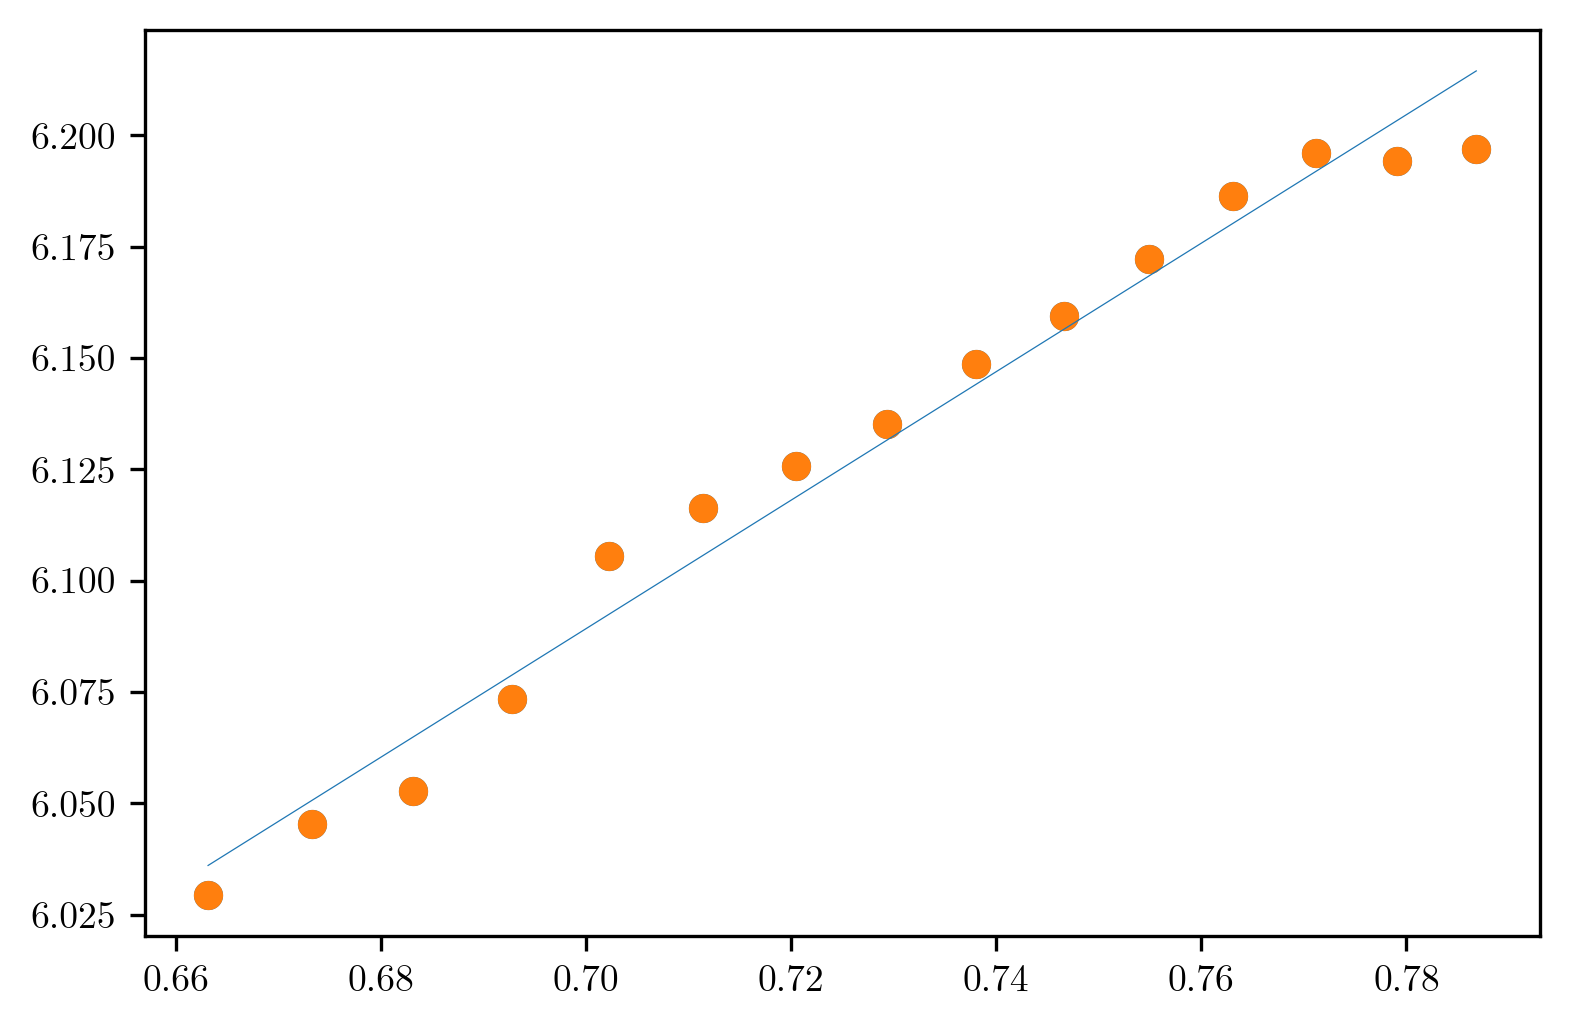

1.4430028014511358 5.079092521385841


In [22]:
lscales=np.log10(arcmins[43:])
lSF=np.log10(SF[1,43:])

plt.figure(dpi=300)
plt.scatter(lscales,lSF)
lm,lc=np.polyfit(lscales,lSF,1)
plt.plot(lscales,lm*lscales+lc)
plt.scatter(lscales,lSF)
plt.show()
print(lm,lc)

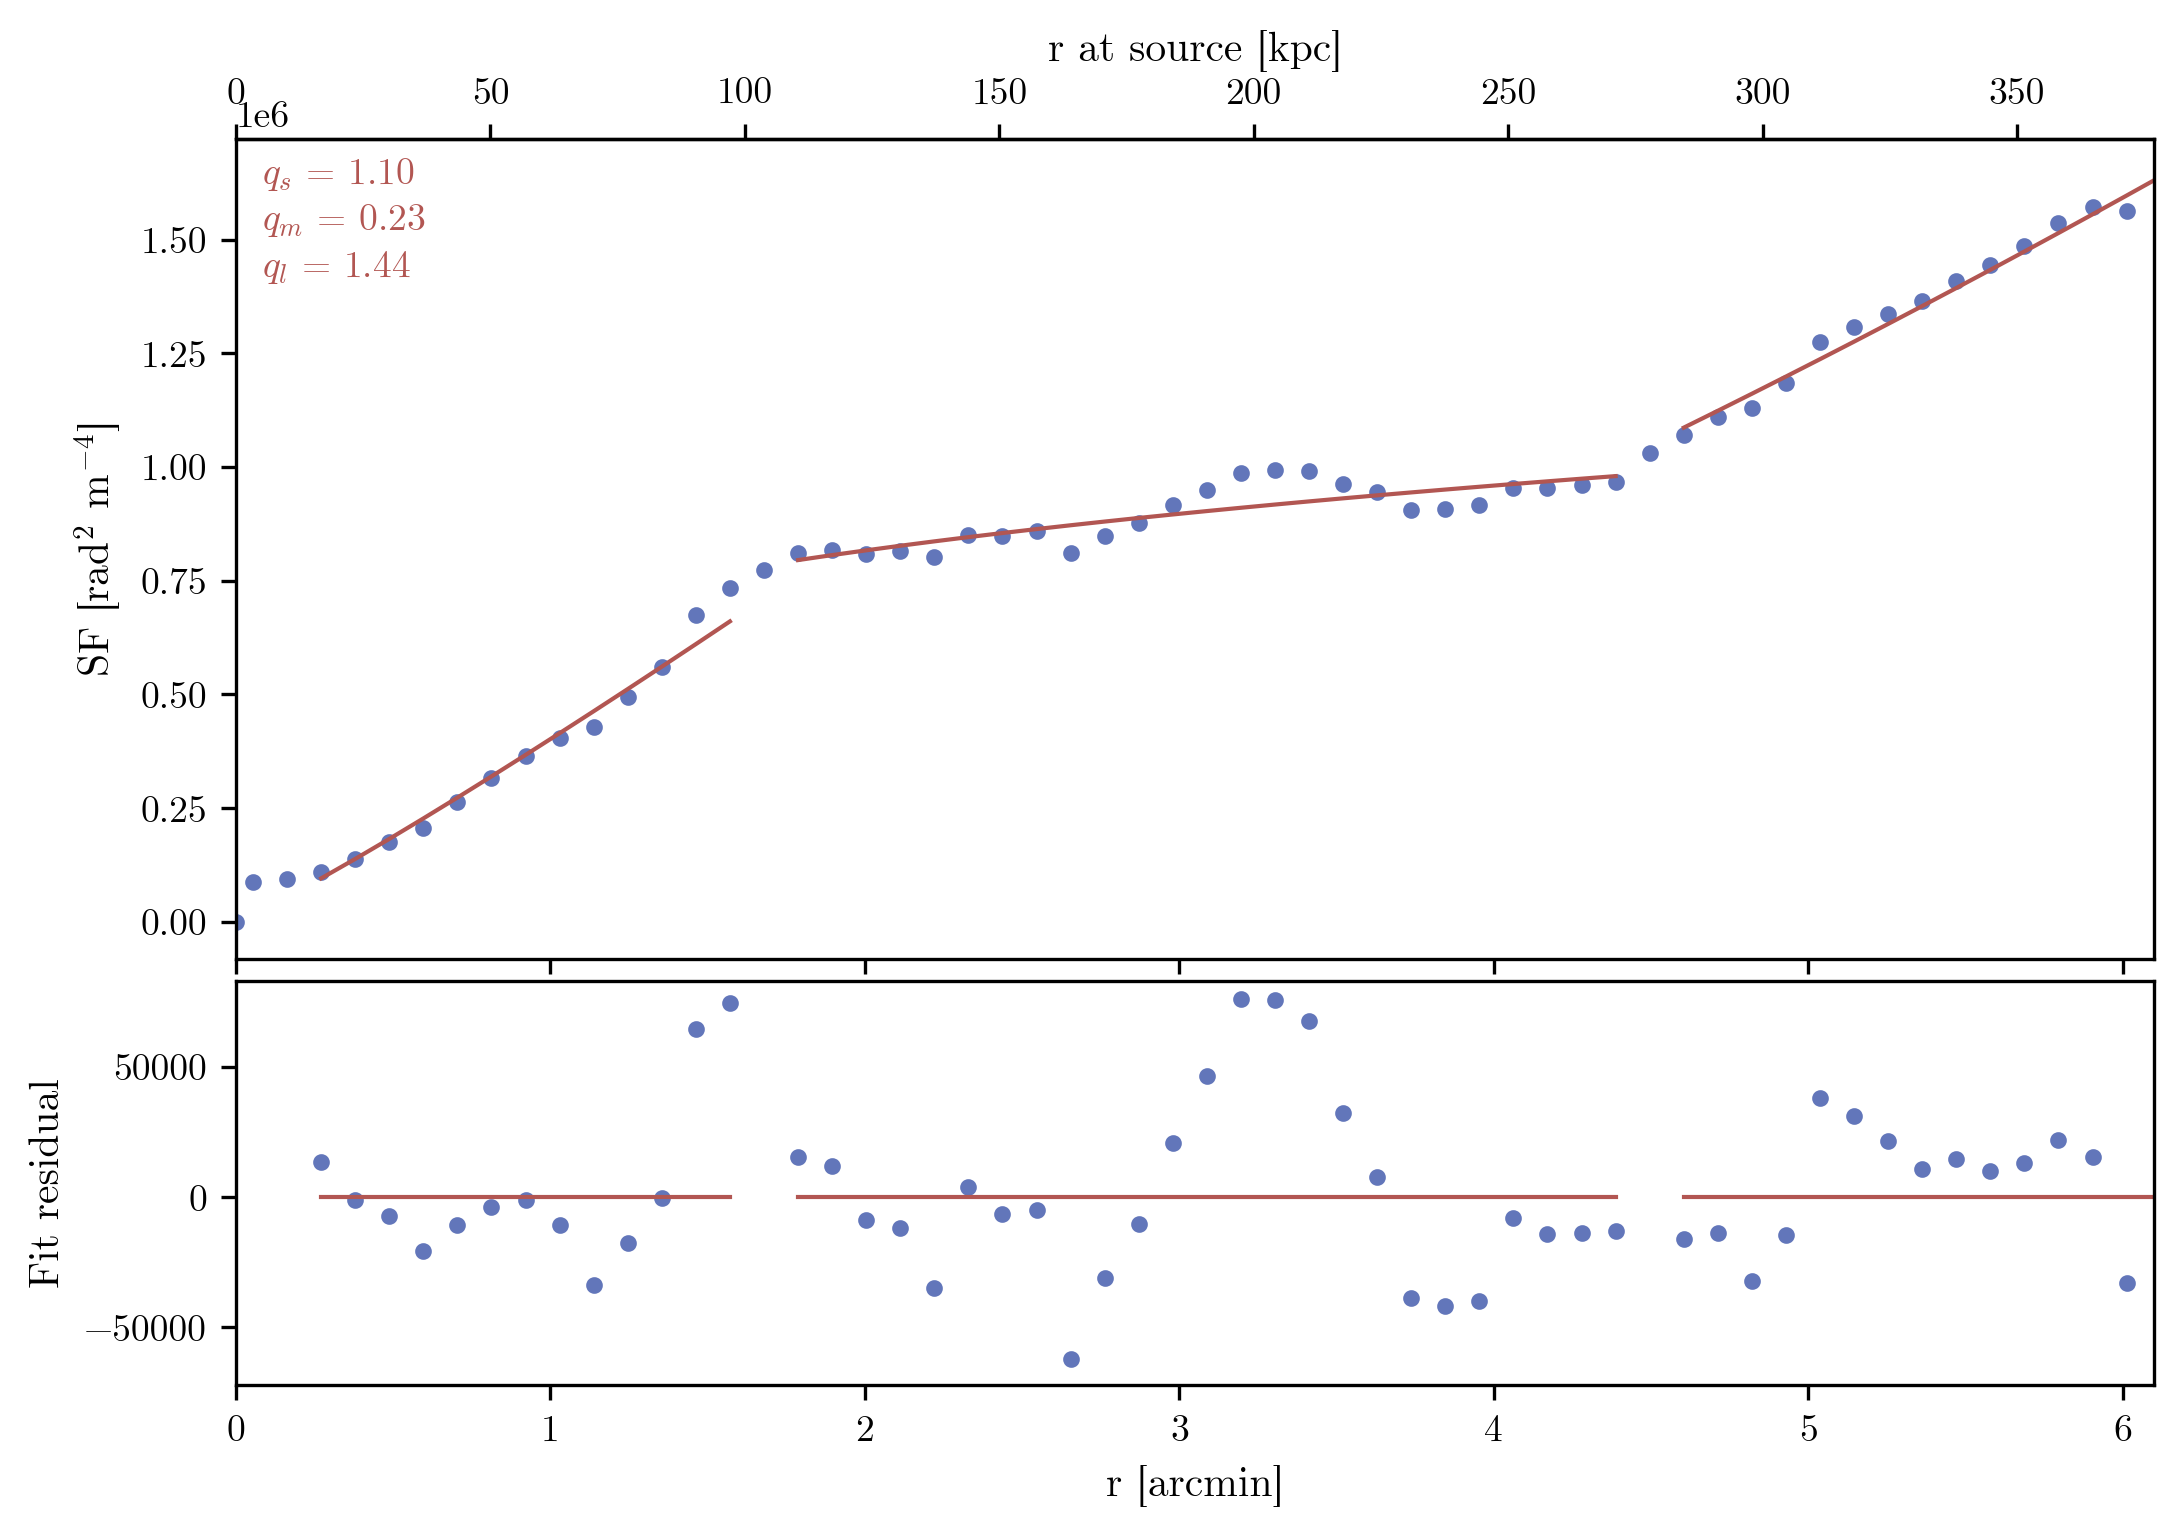

In [23]:
plt.figure(dpi=300,figsize=(8.25,2*8.25/3))
ax=plt.subplot(211,adjustable='box')
ax.plot(np.power(10,smallscales),np.power(10,sm*smallscales+sc),color=twilight(0.75),lw=1)
ax.plot(np.power(10,mscales),np.power(10,mm*mscales+mc),color=twilight(0.75),lw=1)
ax.plot(np.power(10,lscales),np.power(10,lm*lscales+lc),color=twilight(0.75),lw=1)
ax.scatter(arcmins,SF[1,:],marker='.',color=twilight(0.25))
secax = ax.secondary_xaxis('top', functions=(arcsectokpc, kpctoarcsec))
secax.set_xlabel('r at source [kpc]')
ax.set_ylabel(r'SF [rad$^{2}$ m$^{-4}$]')
ax.set_xticklabels([])


ax2=plt.subplot(515,adjustable='box')
ax2.scatter(np.power(10,smallscales),np.power(10,scSF)-np.power(10,sm*smallscales+sc),marker='.',color=twilight(0.25))
ax2.scatter(np.power(10,mscales),np.power(10,mSF)-np.power(10,mm*mscales+mc),marker='.',color=twilight(0.25))
ax2.scatter(np.power(10,lscales),np.power(10,lSF)-np.power(10,lm*lscales+lc),marker='.',color=twilight(0.25))
ax2.plot(np.power(10,smallscales),np.zeros(shape=smallscales.shape),color=twilight(0.75),lw=1)
ax2.plot(np.power(10,mscales),np.zeros(shape=mscales.shape),color=twilight(0.75),lw=1)
ax2.plot(np.power(10,lscales),np.zeros(shape=lscales.shape),color=twilight(0.75),lw=1)

ax.annotate(text=r'$q_s$ = {:.2f}'.format(sm),xy=(0.12,0.88),xycoords='figure fraction',color=twilight(0.75),fontsize=SMALL_SIZE)
ax.annotate(text=r'$q_m$ = {:.2f}'.format(mm),xy=(0.12,0.85),xycoords='figure fraction',color=twilight(0.75),fontsize=SMALL_SIZE)
ax.annotate(text=r'$q_l$ = {:.2f}'.format(lm),xy=(0.12,0.82),xycoords='figure fraction',color=twilight(0.75),fontsize=SMALL_SIZE)


ax2.set_xlabel('r [arcmin]')
ax2.set_ylabel('Fit residual')
ax.set_xlim(0,6.1)
ax2.set_xlim(0,6.1)
plt.subplots_adjust(wspace=0, hspace=-0.48)
